# **Benchmark - XAI**

This benchmark brings together the analyzes carried out by the authors **(-----anonymous due to article review----)** in the article entitled "*Does Dataset Complexity Matters for Model Explainers?*".

**Abstract:**

Strategies based on Explainable Artificial Intelligence - XAI have emerged in computing aiming to promote a better understanding of predictions made by black-box models. Most of today's XAI-based tools explain these types of models, generating rankings of attributes aimed at explaining the same, that is, analysis of Attribute Importance. There is no consensus on which XAI tool generates a general rank of explanability, for this reason, several proposals for tools have emerged (Ciu, Dalex, Eli5, Lofo, Shap and Skater). Here, we present a experimental benchmark of explainable AI techniques capable of producing global explanability ranks in an agnostic way to models and based on tabular data related to different problems. Seeking to answer questions such as "*Are the explanations generated by the different tools the same, similar or different?*" and "*How data complexity plays along model explainability?*". The results from the construction of 82 computational models and 592 ranks, give us some light on the other side of the problem of explicability, dataset complexity!


## Methodology

The following is a schematic figure that summarizes all the steps performed on this notebook.

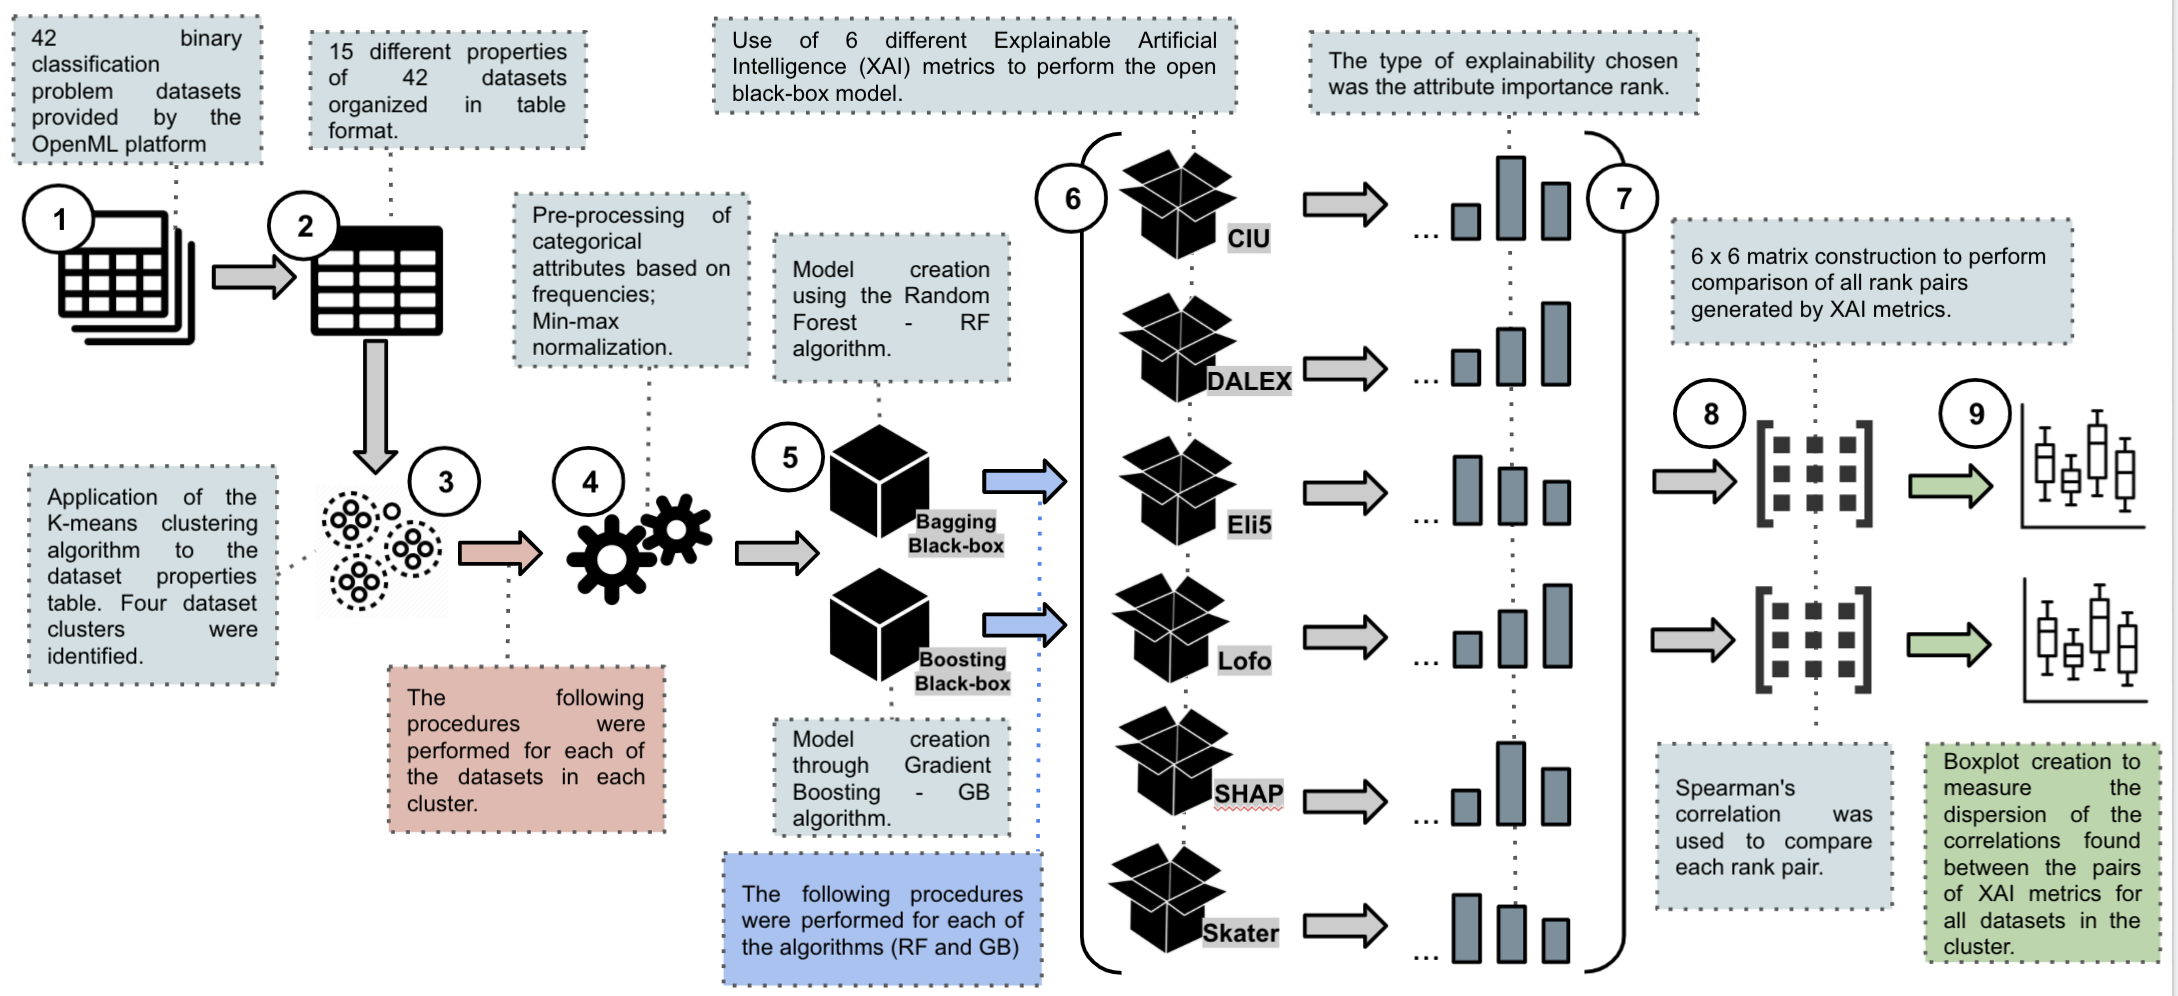



Generate files for download?


In [57]:
do_download = True #when change to True, run all notebook!

## Install dependences

Set of libraries and software packages needed to run all program steps.

Note, specific versions are required in some cases!

In [58]:
# XAI Tools
!pip install lofo-importance
!pip install git+https://github.com/oracle/Skater.git
!pip install info_gain
!pip install shap
!pip install eli5
!pip install dalex
!pip install py-ciu
!pip install plotly
!pip install scikit_posthocs
!pip install openml
!pip install imbalanced-learn

import eli5
import shap
import dalex as dx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scikit_posthocs as sp
import numpy as np
import openml
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import statistics
import os
import gc
import math
import matplotlib.cm as cm

from ciu import determine_ciu
from lofo import LOFOImportance, FLOFOImportance, Dataset
from info_gain import info_gain
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import friedmanchisquare
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_samples, silhouette_score
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import preprocessing

  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-gu2vlz7y
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-gu2vlz7y
  Created wheel for skater: filename=skater-1.1.2b1-cp37-none-any.whl size=4637029 sha256=3be5260c6cd8a18f633ff1776364e700ef38b40a04344f5c5c7d6a0d44f2460c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3x7iza8q/wheels/c2/28/b9/9b4dc6f662963a32fef3ae5e91922fbfda144272498b1c9412
Successfully built skater


## Util

In [59]:
class Util():
  def is_int(n):
    isInteger = False
    for i in range(len(n)):
      if isinstance(n[i],float):
        return False
    return True

## XAI tools (Ciu,Dalex, Eli5, Lofo, Shap and Skater)

Class that implements all the Explainable Artificial Intelligence tools **(Ciu,Dalex, Eli5, Lofo, Shap and Skater)** tested in the study. Generally speaking, each method of the class receives its mandatory parameters (usually test/training data and model to be used) and returns a rank of the most important attributes (explicability).



In [60]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 14:32:39 2021

@author: Jose Ribeiro
"""


class ExplainableTools():
  def explainRankByLofo(model,X,Y,names_x_attributes):
    df = X.copy()
    df['class'] = Y.to_list()
    dataset = Dataset(df=df, target="class", features=names_x_attributes)
    fi = LOFOImportance(dataset, scoring='accuracy', model=model)
    importances = fi.get_importance()
    importances = importances.sort_values(by=['importance_mean','feature'],ascending=False) #fix problem of equals values of explaination
    return importances['feature'].to_list()

  def explainRankByEli5(model, names_x_attributes):
      rank = eli5.explain_weights_df(model,  feature_names = names_x_attributes)
      rank = rank.sort_values(by=['weight','feature'],ascending=False) #fix problem of equals values of explaination
      return rank['feature'].to_list()     


  def explainRankByKernelShap(model,x_features_names, X,is_gradient=False): # shap.sample(data, K) or shap.kmeans(data, K)
    np.random.seed(0)
    explainer = shap.KernelExplainer(model.predict_proba, X[:],nsamples=len(x_features_names))
    shap_values = explainer.shap_values(X[:])
    if is_gradient == False:
        vals= np.abs(shap_values).sum(1)
    else:
        vals= np.abs([shap_values]).sum(1) #correction []
    temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value']) 
    temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination
    return list(temp_df['feat_name'])
    

  def explainRankByTreeShap(model, x_features_names, X, is_gradient=False):
      np.random.seed(0)
      shap_values = shap.TreeExplainer(model).shap_values(X)
      if is_gradient == False:
        vals= np.abs(shap_values).mean(0)
      else:
        vals= np.abs([shap_values]).mean(0) #correction []  
      temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value']) 
      temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination
      
      return temp_df['feat_name'].to_list()
  
  def explainRankByCiu(model, x, feature_names,context_dic,rank):
    
    def _makeRankByCu(ciu):
      df_cu = pd.DataFrame(list(ciu.cu.items()), columns=['attribute', 'cu'])
      df_cu = df_cu.sort_values(by='cu', ascending=False)
      #ciu.plot_cu()
      return df_cu['attribute'].to_list()
    
    def _makeRankByCi(ciu):
      df_ci = pd.DataFrame(list(ciu.ci.items()), columns=['attribute', 'ci'])
      df_ci = df_ci.sort_values(by=['ci','attribute'], ascending=False) #fix problem of equals values of explaination
      return df_ci['attribute'].to_list()

    case = x.values[0]
    example_prediction = model.predict([x.values[0]])
    example_prediction_probs = model.predict_proba([x.values[0]])
    prediction_index = list(example_prediction_probs[0]).index(max(example_prediction_probs[0]))

    ciu = determine_ciu(x.iloc[0, :].to_dict(), model.predict_proba, context_dic,
      10000,prediction_index,)
    
    if rank == 'ci':
      result = _makeRankByCi(ciu)
    else:
      if rank == 'cu':
        result = _makeRankByCu(ciu)
      else:
        result == {}
    
    #ciu
    return result

  def explainRankByAlibi(model_path,X_train): # -- deprecated
    model = tf.keras.models.load_model(model_path)
    ig  = IntegratedGradients(model, layer=None, method="gausslegendre",
                          n_steps=50, internal_batch_size=100)
    explanation = ig.explain(X_train, baselines=None, target=None)
    attributions = explanation.attributions
    return attributions

  def explainRankSkater(model, X, x_features_names):
    interpreter = Interpretation(X.to_numpy(), feature_names=x_features_names)
    model_new = InMemoryModel(model.predict_proba,examples=X.to_numpy(),probability=True)
    rank = interpreter.feature_importance.feature_importance(model_new,ascending=False, progressbar=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list() 
    
  def explainRankDalex(model, X_train, y_train):
    explainer = dx.Explainer(model, X_train, y_train,verbose=False)
    explanation = explainer.model_parts()
    rank = explanation.result
    rank = rank[rank.variable != '_baseline_']
    rank = rank[rank.variable != '_full_model_']
    rank = rank.sort_values(by=['dropout_loss','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].tolist()


  

  def explainRankByInfoGain(X,Y, attribute_X_names):

    

    def InfoGain(data,attribute_X_name,target_name):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. attribute_X_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """

      def entropy(target_col):
        """
        Calculate the entropy of a dataset.
        The only parameter of this function is the target_col parameter which specifies the target column
        """
        elements,counts = np.unique(target_col,return_counts = True)
        entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
        return entropy

      

      #Calculate the entropy of the total dataset
      total_entropy = entropy(data[target_name])
      
      ##Calculate the entropy of the dataset
      
      #Calculate the values and the corresponding counts for the split attribute 
      vals,counts= np.unique(data[attribute_X_name],return_counts=True)
      
      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[attribute_X_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
      
      #Calculate the information gain
      result = total_entropy - Weighted_Entropy

      return result

    data = X.copy()
    target_name = 'class'
    data[target_name] = Y.to_list()

    rank = pd.Series([InfoGain(data,feature,target_name) for feature in attribute_X_names], index=attribute_X_names).sort_values(ascending=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list() 
    


## Preprocess

Class that performs all the pre-processing of the datasets used in the study. It was decided to implement a method for each dataset used, in order to allow greater control over data transformations - --
* Min-max normalization;
* Conversion from categorical to numeric attribute based on frequency;
* Conversion of boolean attributes to integers.

In [61]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 14:55:08 2021

@author: Jose Ribeiro
"""
class PreprocessDefault():

  def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

  def normalize(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        if(len(df_norm[column].unique()) > 1): #fix NaN generation
          df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        else:
          df_norm[column] = 0
    return df_norm

  def PreprocessXByDataset(X,datasetName):
          flagThereArePreprocess = False
          
          if datasetName == "credit-g":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                      "checking_status": {"no checking":394, "<0": 274, "0<=X<200":269, ">=200":63},
                      "credit_history": {"existing paid":530, "critical/other existing credit": 293, "delayed previously":88, "all paid":49, "no credits/all paid":40},
                      "purpose": {"radio/tv":280, "new car":234, "furniture/equipment":181, "used car":103, "business": 97, "education":50, "repairs":  22, "domestic appliance":12, "other":12, "retraining":9},
                      "savings_status": {"<100": 603, "no known savings":183, "100<=X<500":103, "500<=X<1000":63, ">=1000":48},
                      "employment": {"1<=X<4":339, ">=7":253, "4<=X<7":174, "<1":172, "unemployed":62},
                      "personal_status": {"male single":548, "female div/dep/mar":310, "male mar/wid":92, "male div/sep":50},
                      "other_parties": {"none":907, "guarantor":52, "co applicant":41},
                      "property_magnitude": {"car":332, "real estate":282, "life insurance":232, "no known property":154},
                      "other_payment_plans": {"none":814, "bank":139, "stores":47},
                      "housing": {"own":713, "rent":179, "for free":108},
                      "job": {"skilled":630, "unskilled resident":200, "high qualif/self emp/mgmt":148, "unemp/unskilled non res":22},
                      "own_telephone": {"none":0, "yes":1},
                      "foreign_worker": {"yes":1, "no":0}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()   

          if datasetName == "blood-transfusion-service-center":
              flagThereArePreprocess = True
              print("All numeric")
          
          if datasetName == "monks-problems-2":
              flagThereArePreprocess = True
              X.attr1 = X.attr1.astype(int);
              X.attr2 = X.attr2.astype(int);
              X.attr3 = X.attr3.astype(int);
              X.attr4 = X.attr4.astype(int);
              X.attr5 = X.attr5.astype(int);
              X.attr6 = X.attr6.astype(int);

          if datasetName == "tic-tac-toe":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                      "top-left-square": {"x": 418, "o": 335, "b":205},
                      "top-middle-square": {"x": 378, "o": 330, "b": 250},
                      "top-right-square": {"x": 418, "o": 335, "b":205},
                      "middle-left-square": {"x": 378, "o": 330,"b":250},
                      "middle-middle-square": {"x": 458, "o": 340, "b":160},
                      "middle-right-square": {"x": 378, "o": 330, "b":250},
                      "bottom-left-square": {"x": 418, "o": 335, "b": 205},
                      "bottom-middle-square": {"x": 378, "o": 330,"b": 250},
                      "bottom-right-square": {"x": 418, "o": 335,"b":205}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "monks-problems-1":
              flagThereArePreprocess = True
              X.attr1 = X.attr1.astype(int);
              X.attr2 = X.attr2.astype(int);
              X.attr3 = X.attr3.astype(int);
              X.attr4 = X.attr4.astype(int);
              X.attr5 = X.attr5.astype(int);
              X.attr6 = X.attr6.astype(int);


          if datasetName == "steel-plates-fault":
              flagThereArePreprocess = True
              X.columns = [
                            "X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas",
                            "X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity",
                            "Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400",
                            "Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index",
                            "Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas",
                            "Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas",
                            "Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps"
                            ]
              print("All numeric")
              X.head()

          if datasetName == "kr-vs-kp":
              flagThereArePreprocess = True
              cleanup_nums = {
                      "bkblk":{ "f":2839,"t":357},
                      "bknwy":{ "f":2971,"t":225},
                      "bkon8":{ "f":3076,"t":120},
                      "bkona":{ "f":2874,"t":322},
                      "bkspr":{ "f":2129,"t":1067},
                      "bkxbq":{ "f":1722,"t":1474},
                      "bkxcr":{ "f":2026,"t":1170},
                      "bkxwp":{ "f":2500,"t":696},
                      "blxwp":{ "f":1980,"t":1216},
                      "bxqsq":{ "f":2225,"t":971},
                      "cntxt":{ "f":1817,"t":1379},
                      "dsopp":{ "f":2860,"t":336},
                      "dwipd":{ "g":991,"l":2205},
                      "hdchk":{ "f":3181,"t":15},
                      "katri":{ "b":224,"n":2526,"w":446},
                      "mulch":{ "f":3040,"t":156},
                      "qxmsq":{ "f":3099,"t":97},
                      "r2ar8":{ "f":1000,"t":2196},
                      "reskd":{ "f":3170,"t":26},
                      "reskr":{ "f":2714,"t":482},
                      "rimmx":{ "f":2612,"t":584},
                      "rkxwp":{ "f":2556,"t":640},
                      "rxmsq":{ "f":3013,"t":183},
                      "simpl":{ "f":1975,"t":1221},
                      "skach":{ "f":3185,"t":11},
                      "skewr":{ "f":980,"t":2216},
                      "skrxp":{ "f":3021,"t":175},
                      "spcop":{ "f":3195,"t":1},
                      "stlmt":{ "f":3149,"t":47},
                      "thrsk":{ "f":3060,"t":136},
                      "wkcti":{ "f":2631,"t":565},
                      "wkna8":{ "f":3021,"t":175},
                      "wknck":{ "f":1984,"t":1212},
                      "wkovl":{ "f":1189,"t":2007},
                      "wkpos":{ "f":851,"t":2345},
                      "wtoeg":{ "n":2407,"t":789}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "qsar-biodeg":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "wdbc":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "phoneme":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "diabetes":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ozone-level-8hr":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "eeg-eye-state":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "climate-model-simulation-crashes":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "spambase":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ilpd":
              flagThereArePreprocess = True
              X.V2 = X.V2.map({"Female":1, "Male":0})
              X.V2 = X.V2.astype(int);

          if datasetName == "pc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "pc3":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "banknote-authentication":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "pc4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mozilla4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "monks-problems-3":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                  "attr1":{ "1":192,"2":184,"3":178},
                  "attr2":{ "1":183,"2":186,"3":185},
                  "attr3":{ "1":281,"2":273},
                  "attr4":{ "1":184,"2":182,"3":188},
                  "attr5":{ "1":140,"2":139,"3":136,"4":139},
                  "attr6":{ "1":275,"2":279}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()


          if datasetName == "PhishingWebsites":
              flagThereArePreprocess = True
              cleanup_nums = {
                            "having_IP_Address":{ "-1":3793,"1":7262},
                            "URL_Length":{ "-1":8960,"0":135,"1":1960},
                            "Shortining_Service":{ "-1":1444,"1":9611},
                            "having_At_Symbol":{ "-1":1655,"1":9400},
                            "double_slash_redirecting":{ "-1":1429,"1":9626},
                            "Prefix_Suffix":{ "-1":9590,"1":1465},
                            "having_Sub_Domain":{ "-1":3363,"0":3622,"1":4070},
                            "SSLfinal_State":{ "-1":3557,"0":1167,"1":6331},
                            "Domain_registeration_length":{ "-1":7389,"1":3666},
                            "Favicon":{ "-1":2053,"1":9002},
                            "port":{ "-1":1502,"1":9553},
                            "HTTPS_token":{ "-1":1796,"1":9259},
                            "Request_URL":{ "-1":4495,"1":6560},
                            "URL_of_Anchor":{ "-1":3282,"0":5337,"1":2436},
                            "Links_in_tags":{ "-1":3956,"0":4449,"1":2650},
                            "SFH":{ "-1":8440,"0":761,"1":1854},
                            "Submitting_to_email":{ "-1":2014,"1":9041},
                            "Abnormal_URL":{ "-1":1629,"1":9426},
                            "Redirect":{ "0":9776,"1":1279},
                            "on_mouseover":{ "-1":1315,"1":9740},
                            "RightClick":{ "-1":476,"1":10579},
                            "popUpWidnow":{ "-1":2137,"1":8918},
                            "Iframe":{ "-1":1012,"1":10043},
                            "age_of_domain":{ "-1":5189,"1":5866},
                            "DNSRecord":{ "-1":3443,"1":7612},
                            "web_traffic":{ "-1":2655,"0":2569,"1":5831},
                            "Page_Rank":{ "-1":8201,"1":2854},
                            "Google_Index":{ "-1":1539,"1":9516},
                            "Links_pointing_to_page":{ "-1":548,"0":6156,"1":4351},
                            "Statistical_report":{ "-1":1550,"1":9505}
                        }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()


          if datasetName == "churn":
              flagThereArePreprocess = True
              cleanup_nums = {
                  "area_code":{ "408":1259,"415":2495,"510":1246},
                  "international_plan":{ "0":4527,"1":473},
                  "voice_mail_plan":{ "0":3677,"1":1323},
                  "number_customer_service_calls":{ "0":1023,"1":1786,"2":1127,"3":665,"4":252,"5":96,"6":34,"7":13,"8":2,"9":2}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "Australian":
              flagThereArePreprocess = True
              cleanup_nums = {
                  "A1":{ "0":222,"1":468},
                  "A4":{ "1":163,"2":525,"3":2},
                  "A5":{ "1":53,"2":30,"3":59,"4":51,"5":10,"6":54,"7":38,"8":146,"9":64,"10":25,"11":78,"12":3,"13":41,"14":38},
                  "A6":{ "1":57,"2":6,"3":8,"4":408,"5":59,"7":6,"8":138,"9":8},
                  "A8":{ "0":329,"1":361},
                  "A9":{ "0":395,"1":295},
                  "A11":{ "0":374,"1":316},
                  "A12":{ "1":57,"2":625,"3":8}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "autoUniv-au1-1000":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "haberman":
                flagThereArePreprocess = True
                cleanup_nums = {
                    "Patients_year_of_operation":{ "58":36,"59":27,"60":28,"61":26,"62":23,"63":30,"64":31,"65":28,"66":28,"67":25,"68":13,"69":11}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "heart-statlog":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "ionosphere":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "sonar":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "Satellite":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "SPECT":
                flagThereArePreprocess = True
                cleanup_nums = {
                    "F1":{ "0":148,"1":119},
                    "F2":{ "0":201,"1":66},
                    "F3":{ "0":162,"1":105},
                    "F4":{ "0":191,"1":76},
                    "F5":{ "0":159,"1":108},
                    "F6":{ "0":204,"1":63},
                    "F7":{ "0":191,"1":76},
                    "F8":{ "0":153,"1":114},
                    "F9":{ "0":184,"1":83},
                    "F10":{ "0":166,"1":101},
                    "F11":{ "0":202,"1":65},
                    "F12":{ "0":188,"1":79},
                    "F13":{ "0":135,"1":132},
                    "F14":{ "0":186,"1":81},
                    "F15":{ "0":220,"1":47},
                    "F16":{ "0":184,"1":83},
                    "F17":{ "0":229,"1":38},
                    "F18":{ "0":232,"1":35},
                    "F19":{ "0":201,"1":66},
                    "F20":{ "0":181,"1":86},
                    "F21":{ "0":170,"1":97},
                    "F22":{ "0":157,"1":110}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "analcatdata_boxing1":
                flagThereArePreprocess = True
                cleanup_nums = {
                      "Judge":{ "Associated_Press":12,"Boxing_Monthly-Leach":12,"Boxing_Times":12,"E._Williams":12,"ESPN":12,"HBO-Lederman":12,"L._OConnell":12,"S._Christodoulu":12,"Sportsline":12,"Sportsticker":12},
                      "Official":{ "No":84,"Yes":36},
                      "Round":{ "1":10,"2":10,"3":10,"4":10,"5":10,"6":10,"7":10,"8":10,"9":10,"10":10,"11":10,"12":10}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "aids":
                flagThereArePreprocess = True
                cleanup_nums = {
                      "Age":{ "15-24":10,"25-34":10,"35-44":10,"45-54":10,"55_&_older":10},
                      "Race":{ "American_Indian_&_Alaska_Native":10,"Asian_&_Pacific_Islander":10,"Black_not_Hispanic":10,"Hispanic":10,"White_not_Hispanic":10},
                      }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "servo":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "motor":{ "A":36,"B":36,"C":40,"D":22,"E":33},
                    "screw":{ "A":42,"B":35,"C":31,"D":30,"E":29},
                    "pgain":{ "3":50,"4":66,"5":26,"6":25},
                    "vgain":{ "1":47,"2":49,"3":27,"4":22,"5":22}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "analcatdata_creditscore":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Own.home":{ "0":64,"1":36},
                    "Self.employed":{ "0":95,"1":5},
                    "Derogatory.reports":{ "0":82,"1":10,"2":3,"3":3,"4":1,"7":1}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "analcatdata_boxing2":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Judge":{ "Associated_Press":12,"B._Logist":12,"G._Hamada":12,"HBO-Lederman":12,"J._Roth":12,"Las_Vegas_Review-Journal":12,"Los_Angeles_Times-Kawakami":12,"Los_Angeles_Times-Springer":12,"Sportsticker":12,"USA_Today":12,"van_de_Wiele":12},
                    "Official":{ "No":96,"Yes":36},
                    "Round":{ "1":11,"2":11,"3":11,"4":11,"5":11,"6":11,"7":11,"8":11,"9":11,"10":11,"11":11,"12":11}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "datatrieve":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "analcatdata_lawsuit":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Minority":{ "0":167,"1":97}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "pc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "delta_ailerons":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ar4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ar6":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc3":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mw1":
              print("All numeric")

          if datasetName == "jEdit_4.0_4.2":
              print("All numeric")

          if datasetName == "prnn_crabs":
              flagThereArePreprocess = True
              cleanup_nums = {
                      "sex":{ "Female":1,"Male":0}
                    }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if flagThereArePreprocess == False:
            print("@@@@ NOTE>: There arent preprocess in X dataset ", datasetName," @@@@")

          return X

  def PreprocessYByDataset(Y,datasetName):
          flagThereArePreprocess = False
          if datasetName == "credit-g":
              flagThereArePreprocess = True
              Y = Y.map({"good":1, "bad":0})

          if datasetName == "blood-transfusion-service-center":
              flagThereArePreprocess = True
              Y = Y.astype(int)  

          if datasetName == "monks-problems-2":
              flagThereArePreprocess = True
              Y = Y.astype(int);
          
          if datasetName == "tic-tac-toe":
              flagThereArePreprocess = True
              Y = Y.map({"positive":1, "negative":0})

          if datasetName == "monks-problems-1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "steel-plates-fault":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kr-vs-kp":
              flagThereArePreprocess = True
              Y = Y.map({"won":1, "nowin":0})

          if datasetName == "qsar-biodeg":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "wdbc":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "phoneme":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "diabetes":
              flagThereArePreprocess = True
              Y = Y.map({"tested_positive":1, "tested_negative":0})

          if datasetName == "ozone-level-8hr":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kc2":
              flagThereArePreprocess = True
              Y = Y.map({"yes":1, "no":0})

          if datasetName == "eeg-eye-state":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "climate-model-simulation-crashes":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "spambase":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kc1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "ilpd":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc3":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "banknote-authentication":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc4":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "mozilla4":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "monks-problems-3":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "PhishingWebsites":
              flagThereArePreprocess = True
              Y = Y.map({"1":1, "-1":0})

          if datasetName == "churn":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "Australian":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "autoUniv-au1-1000":
              flagThereArePreprocess = True
              Y = Y.map({"class1":1, "class2":0})

          if datasetName == "haberman":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "heart-statlog":
              flagThereArePreprocess = True
              Y = Y.map({"absent":1, "present":0})

          if datasetName == "ionosphere":
              flagThereArePreprocess = True
              Y = Y.map({"b":1, "g":0});

          if datasetName == "sonar":
              flagThereArePreprocess = True
              Y = Y.map({"Rock":1, "Mine":0});

          if datasetName == "Satellite":
              flagThereArePreprocess = True
              Y = Y.map({"Normal":1, "Anomaly":0});

          if datasetName == "SPECT":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_boxing1":
              flagThereArePreprocess = True
              Y = Y.map({"Holyfield":1, "Lewis":0});

          if datasetName == "aids":
              flagThereArePreprocess = True
              Y = Y.map({"Female":1, "Male":0});

          if datasetName == "servo":
              flagThereArePreprocess = True
              Y = Y.map({"P":1, "N":0});

          if datasetName == "analcatdata_creditscore":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_boxing2":
              flagThereArePreprocess = True
              Y = Y.map({"de_la_Hoya":1, "Trinidad":0});

          if datasetName == "datatrieve":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_lawsuit":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc2":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "delta_ailerons":
              flagThereArePreprocess = True
              Y = Y.map({"P":1, "N":0});

          if datasetName == "mc1":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "ar4":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "ar6":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "kc3":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "mc2":
              flagThereArePreprocess = True
              Y = Y.map({ False: 1, True: 0});

          if datasetName == "mw1":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "jEdit_4.0_4.2":
              flagThereArePreprocess = True
              Y = Y.map({True:1, False:0});

          if datasetName == "prnn_crabs":
              flagThereArePreprocess = True
              Y = Y.map({"blue_form":1, "orange_form":0});
          
          if flagThereArePreprocess == False:
            print("@@@@ NOTE>: There arent preprocess in Y dataset ", datasetName," @@@@")

          return Y




## Analysis

Class that has all the functions for model performance analysis and also general data analysis. That is, functions for the calculations of:
* Accuracy;
* Precision;
* Confusion matrix;
* Cross validation;
* Friedman test;
* Spearman's coefficient.

In [62]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 16:02:02 2021

@author: Jose Ribeiro
"""

class AnalysisDefault():

  do_download_files = do_download 

  def calcAccuracyPrecisionRecallByModel(y_test,y_pred):
      ac = [accuracy_score(y_test, y_pred)]
      pr = [precision_score(y_test, y_pred)]
      re = [recall_score(y_test, y_pred)]
      
      d = {'Accuracy': ac,
              'Precision': pr,
              'Recall': re}
      dataframe_analisys = pd.DataFrame(data=d)
      print("")
      print(dataframe_analisys)
      print("")
      return ac, pr, re

  def plotConfusionMatrix(model,X_test,y_test,file_name):
      plot_confusion_matrix(model, X_test, y_test,normalize='true')
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      
      plt.show()

  def calcConfusionMatrix(y_test, y_pred, name_model):
      m = confusion_matrix(y_test, y_pred,normalize='true')
      
      print("## confusion matrix ",name_model," ##")
      print("  Correct True: ",m[0][0]," Uncorrect True: ",m[0][1])
      print("Uncorrect True: ",m[1][0],"   Correct True: ",m[1][1])
      return m[0][0], m[1][1]
      
      

  def calcCrossValidation(model, X_train, y_train, cv, plotGraph):
      hit_rates = cross_val_score(model, X_train, y_train, cv=cv)
      if plotGraph == True:
          sns.kdeplot(data=hit_rates,legend=True,bw_method=0.7)
      
      return hit_rates

  def plotComparationCrossValidation(hr_rf,hr_gb,hr_dt, file_name):
      dt_tmp = {
            'GB':hr_gb,
            'DT':hr_dt,
            'RF':hr_rf
            }
      dt_tmp = pd.DataFrame(dt_tmp)

      fig, ax = plt.subplots(figsize=(8,6))
      sns.kdeplot(data=dt_tmp,legend=True,bw_method=0.7)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      plt.show()
      
  def plotFriedmanTest(hr_rf,hr_gb,hr_dt, file_name):
      a = [hr_rf.tolist(),hr_gb.tolist(), hr_dt.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['RF','GB', 'DT']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name) 
      plt.show()
      
  def plotFriedmanTestDataProperty(c0,c1,c2, file_name):
      a = [c0.tolist(),c1.tolist(), c2.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['c0','c1', 'c2']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name) 
      plt.show()
      
  def calcSpearmanCoef(d1,d2):
    coef, p = spearmanr(d1, d2)
    alpha = 0.05
    return coef
        
        
        
  #InformationGain
  ###################

  def _entropy(target_col):
      """
      Calculate the entropy of a dataset.
      The only parameter of this function is the target_col parameter which specifies the target column
      """
      elements,counts = np.unique(target_col,return_counts = True)
      entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
      return entropy


  ################### 
      
  ###################


  def calcInfoGain(data,split_attribute_name,target_name="class"):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. split_attribute_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """    
      #Calculate the entropy of the total dataset
      total_entropy = _entropy(data[target_name])
      
      ##Calculate the entropy of the dataset
      
      #Calculate the values and the corresponding counts for the split attribute 
      vals,counts= np.unique(data[split_attribute_name],return_counts=True)
      
      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*_entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
      
      #Calculate the information gain
      Information_Gain = total_entropy - Weighted_Entropy
      return Information_Gain      
      
      

## Datasets list

Listing of datasets that will be loaded directly from the openML cloud.



In [63]:
code_datasets = ['ozone-level-8hr',
                  'sonar',
                  'spambase',
                  'qsar-biodeg',
                  'kc3',
                  'mc1',
                  'pc3',
                  'mw1',
                  'pc4',
                  'kr-vs-kp',
                  'Satellite',
                  'pc2',
                  'ionosphere',
                  'steel-plates-fault',
                  'PhishingWebsites',
                  'wdbc',
                  'SPECT',
                  'kc2',
                  'pc1',
                  'kc1',
                  'credit-g',
                  'churn',
                  'climate-model-simulation-crashes',
                  'Australian',
                  'eeg-eye-state',
                  'heart-statlog',
                  'ilpd',
                  'tic-tac-toe',
                  'jEdit_4.0_4.2',
                  'diabetes',
                  'prnn_crabs',
                  'monks-problems-1',
                  'monks-problems-3',
                  'monks-problems-2',
                  'delta_ailerons',
                  'mozilla4',
                  'phoneme',
                  'blood-transfusion-service-center',
                  'analcatdata_lawsuit',
                  'banknote-authentication',
                  'haberman'
                 ]

## Extract datasets properties

The code below extracts 15 different properties from the dataset listing described above, directly from the OpenML cloud. The result of this code snippet is a table containing all 15 properties of each dataset.

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 26 22:44:05 2019

@author: Lucas Cardoso
"""

list_datasets = code_datasets

#Cria a pasta cache para salvar os dados do OpenML
openml.config.cache_directory = os.path.expanduser(os.getcwd()+'/cache')

#List of all properts of OpenML's dataset
metadados = ['NumberOfInstances', 'NumberOfFeatures', 'NumberOfClasses', 'NumberOfMissingValues', 'NumberOfInstancesWithMissingValues',
             'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 'NumberOfBinaryFeatures', 'StdvNominalAttDistinctValues',
             'MeanNominalAttDistinctValues', 'MeanSkewnessOfNumericAtts', 'MajorityClassPercentage', 'MeanStdDevOfNumericAtts', 'ClassEntropy', 
             'MajorityClassSize', 'MinAttributeEntropy', 'MaxAttributeEntropy', 'MinMeansOfNumericAtts', 'MaxMeansOfNumericAtts', 'Dimensionality', 
             'PercentageOfBinaryFeatures', 'MinNominalAttDistinctValues', 'EquivalentNumberOfAtts', 'MaxNominalAttDistinctValues', 'PercentageOfInstancesWithMissingValues', 
             'MaxSkewnessOfNumericAtts', 'MinStdDevOfNumericAtts', 'PercentageOfMissingValues', 'AutoCorrelation', 'MaxStdDevOfNumericAtts', 'MinorityClassPercentage', 
             'PercentageOfNumericFeatures', 'MeanAttributeEntropy', 'MinorityClassSize', 'PercentageOfSymbolicFeatures','MeanMutualInformation']

#List selected properties
metadados = ['NumberOfFeatures','NumberOfInstances','Dimensionality',
             'PercentageOfBinaryFeatures','StdvNominalAttDistinctValues',
             'MeanNominalAttDistinctValues','ClassEntropy','AutoCorrelation',
             'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 
             'NumberOfBinaryFeatures','PercentageOfSymbolicFeatures',
             'PercentageOfNumericFeatures', 'MajorityClassPercentage', 
             'MinorityClassPercentage']



listDataQltsOnly = {}
list_name = {}
for i in tqdm(range(len(list_datasets))):
    dataset = openml.datasets.get_dataset(list_datasets[i],download_data = False)
    #Original
    #listValues = list(dataset.qualities.values())
    #listKeys = list(dataset.qualities.keys())
    list_name[dataset.dataset_id] = dataset.name
    dataDict = {}
    key = 0
    for j in metadados:
        try:
            if not(math.isnan(dataset.qualities[j])):
                dataDict[j] = dataset.qualities[j]
        except:
            key = 1
            break
    #dataDict["did"] = dataset.dataset_id
    #listDataQlts[i] = dataDict
    if key ==0:
        listDataQltsOnly[dataset.name] = dataDict
    else:
        continue
    
    gc.collect()


df_dataset_properties = pd.DataFrame.from_dict(listDataQltsOnly, orient='index')
if do_download:
  df_dataset_properties.to_csv('df_dataset_properties.csv')



100%|██████████| 41/41 [00:32<00:00,  1.28it/s]


## Clustering

Clustering process of the properties table generated in the previous step. In this case, 3 clusters with adequate distances from each other were identified (calculated using the silhouette algorithm).

In [65]:
#padronization of data
min_max_scaler = preprocessing.MinMaxScaler()
mStandardScaler = preprocessing.StandardScaler()
data_norm = PreprocessDefault.z_score(df_dataset_properties)

Definition of k size

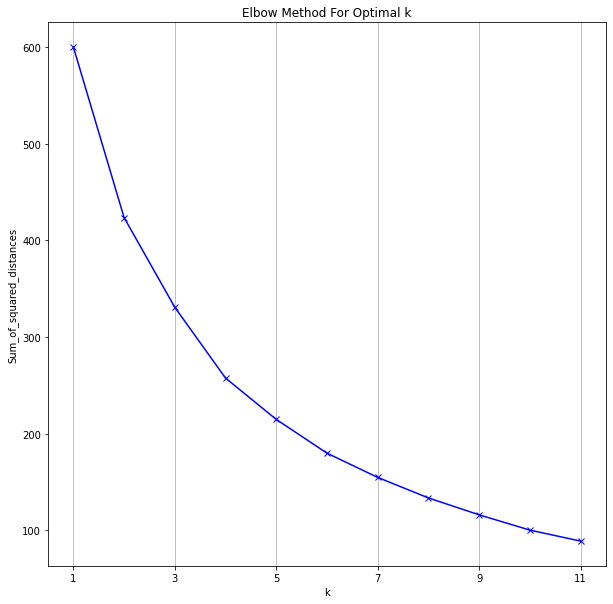

In [66]:
Sum_of_squared_distances = []
n = 12
K = range(1,n)
for k in K:
    km = KMeans(n_clusters=k,random_state=0,init='k-means++',n_init = 1000, max_iter = 5000)
    km = km.fit(data_norm)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(10,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xticks(np.arange(1,n,2))
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3457085530503467
For n_clusters = 3 The average silhouette_score is : 0.2867175583367518


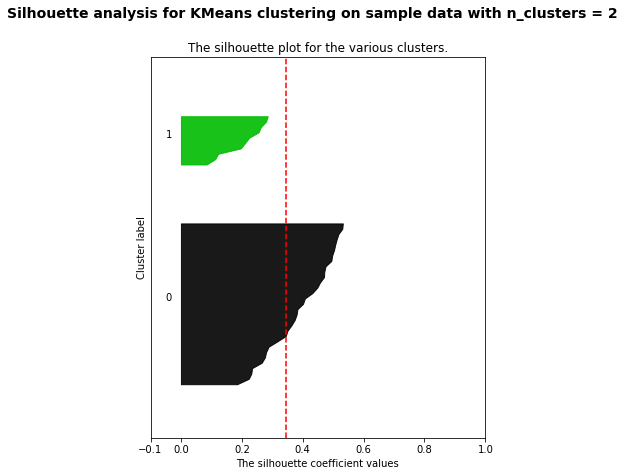

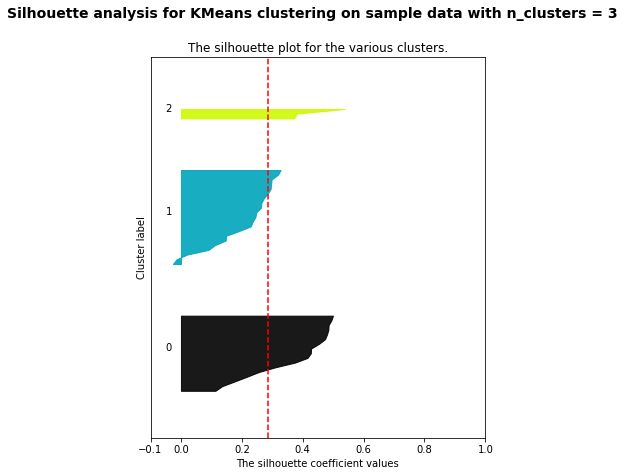

In [67]:
#Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

k = 4
range_n_clusters = range(2, k)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init='k-means++',n_init = 1000, max_iter = 5000)
    cluster_labels = kmeans.fit_predict(data_norm)
    df_dataset_properties['clusters_kmeans'+str(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The best k is 4! Your can see this in silhouette plot.

In [68]:
k_cluster_selected = 'clusters_kmeans3' #identifier ideal k

In [70]:
df_dataset_properties[k_cluster_selected].value_counts()

1    21
0    17
2     3
Name: clusters_kmeans3, dtype: int64

In [71]:
print('Datasets for cluster 0')
df_dataset_properties.query(k_cluster_selected+' == 0').index.to_list()

Datasets for cluster 0


['ozone-level-8hr',
 'sonar',
 'spambase',
 'qsar-biodeg',
 'kc3',
 'mc1',
 'pc3',
 'mw1',
 'pc4',
 'Satellite',
 'pc2',
 'steel-plates-fault',
 'kc2',
 'pc1',
 'kc1',
 'climate-model-simulation-crashes',
 'analcatdata_lawsuit']

In [72]:
print('Datasets for cluster 1')
df_dataset_properties.query(k_cluster_selected+' == 1').index.to_list()

Datasets for cluster 1


['ionosphere',
 'wdbc',
 'credit-g',
 'churn',
 'Australian',
 'eeg-eye-state',
 'heart-statlog',
 'ilpd',
 'tic-tac-toe',
 'jEdit_4.0_4.2',
 'diabetes',
 'prnn_crabs',
 'monks-problems-1',
 'monks-problems-3',
 'monks-problems-2',
 'delta_ailerons',
 'mozilla4',
 'phoneme',
 'blood-transfusion-service-center',
 'banknote-authentication',
 'haberman']

In [73]:
print('Datasets for cluster 2')
df_dataset_properties.query(k_cluster_selected+' == 2').index.to_list()

Datasets for cluster 2


['kr-vs-kp', 'PhishingWebsites', 'SPECT']

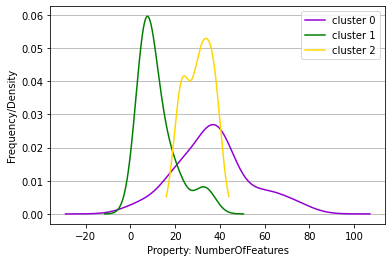

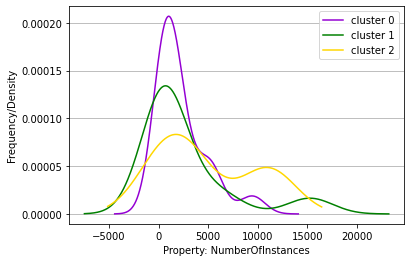

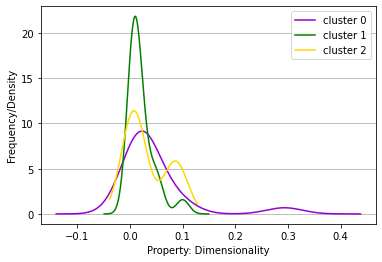

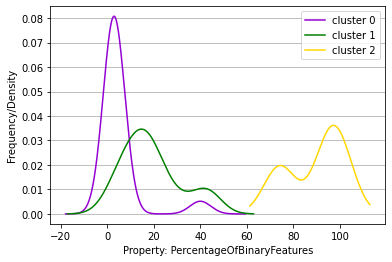

An exception occurred in plot of cluster 0 and col,StdvNominalAttDistinctValues


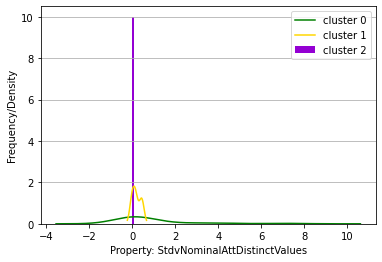

An exception occurred in plot of cluster 0 and col,MeanNominalAttDistinctValues


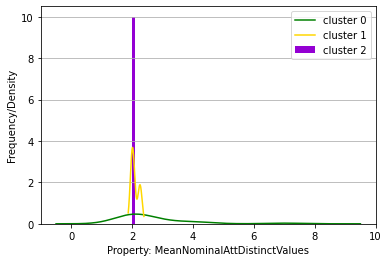

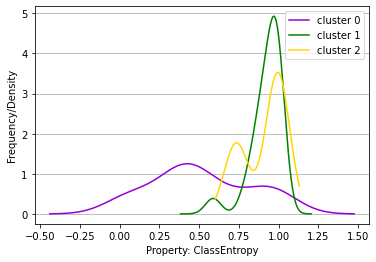

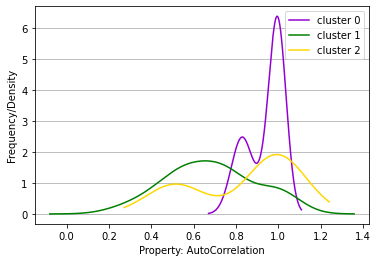

An exception occurred in plot of cluster 2 and col,NumberOfNumericFeatures


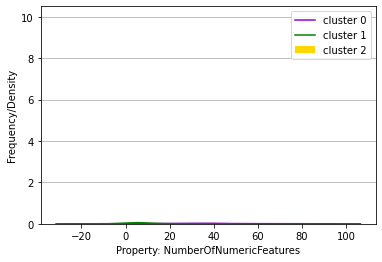

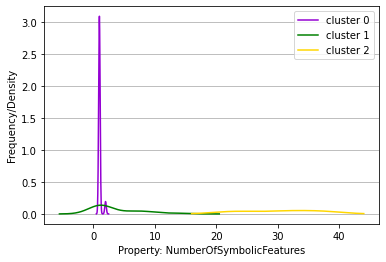

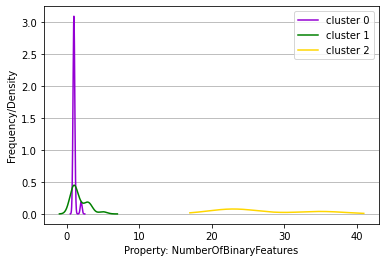

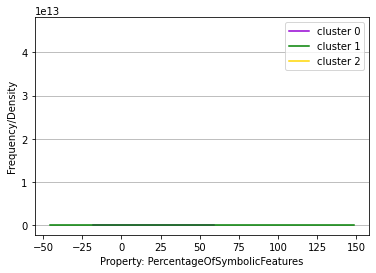

An exception occurred in plot of cluster 2 and col,PercentageOfNumericFeatures


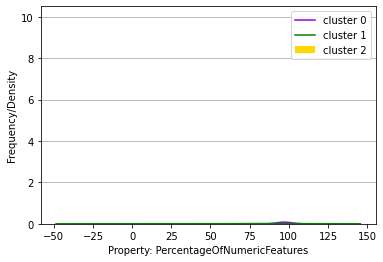

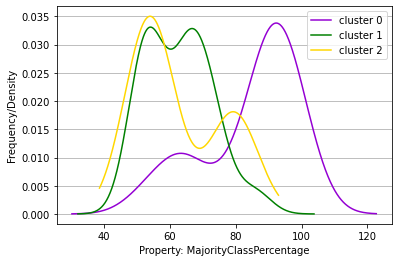

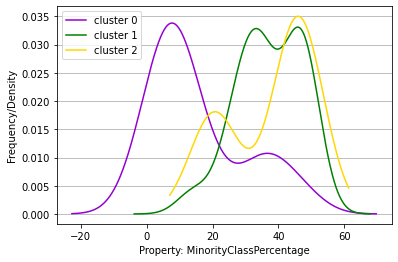

In [74]:
for i, col in enumerate(df_dataset_properties):
  df_cluster_0 = df_dataset_properties.query(k_cluster_selected+' == 0')
  df_cluster_1 = df_dataset_properties.query(k_cluster_selected+' == 1')
  df_cluster_2 = df_dataset_properties.query(k_cluster_selected+' == 2')

  if col.find('cluster') == -1:
    x0 = df_cluster_0[col]
    x1 = df_cluster_1[col] 
    x2 = df_cluster_2[col]

    # Plot
    fig, ax = plt.subplots()
    bw = 0.5
    try:
      x0.plot.kde(ax=ax,bw_method=bw,c='darkviolet')
    except:
      x0.plot.hist(density=True, ax=ax,color='darkviolet')
      print("An exception occurred in plot of cluster 0 and col,"+col)
    
    
    try:
      x1.plot.kde(ax=ax,bw_method=bw,c='green')
    except:
      x1.plot.hist(density=True, ax=ax,color='green')
      print("An exception occurred in plot of cluster 1 and col,"+col)
    
    try:
      x2.plot.kde(ax=ax,bw_method=bw,c='gold')
    except:
      x2.plot.hist(density=True, ax=ax,color='gold')
      print("An exception occurred in plot of cluster 2 and col,"+col)


    
    ax.set_ylabel('Frequency/Density')
    ax.set_xlabel('Property: '+col)
    ax.legend(['cluster 0', 'cluster 1', 'cluster 2'])
    ax.grid(axis='y')
  
    plt.show()

  

In [76]:
#Centroid analysis of the Kmean algorithm.

df_tmp = df_dataset_properties.copy()
df_tmp['index'] = range(0,len(df_tmp))
df_tmp = df_tmp.set_index('index')
index_c0 = df_tmp.query(k_cluster_selected+' == 0').index
index_c1 = df_tmp.query(k_cluster_selected+' == 1').index
index_c2 = df_tmp.query(k_cluster_selected+' == 2').index

for i,col1 in enumerate(data_norm.columns):
  for j,col2 in enumerate(data_norm.columns):
    
      if i < j:
        plt.figure(figsize=(6,6))
        scatter0 = plt.scatter(data_norm.iloc[index_c0][col1], data_norm.iloc[index_c0][col2], s = 100, c = 'darkviolet',alpha=0.7,label='Cluster 0')
        scatter1 = plt.scatter(data_norm.iloc[index_c1][col1], data_norm.iloc[index_c1][col2], s = 100, c = 'green',alpha=0.7,label='Cluster 1')
        scatter2 = plt.scatter(data_norm.iloc[index_c2][col1], data_norm.iloc[index_c2][col2], s = 100, c = 'gold',alpha=0.7,label='Cluster 2')

        scatter5 = plt.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], s = 300, c = 'red',label = 'Centroids',alpha=0.9)
        plt.title('Dataset properties Clusters and Centroids')
        plt.xlabel(col1)
        plt.ylabel(col2)
        
        
        plt.legend()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [79]:
#Minimum and maximum values of each property in specific cluster datasets.
clusters = df_dataset_properties[k_cluster_selected].unique()

for c in clusters:
  query = k_cluster_selected+' == '+str(c)
  df_tmp = df_dataset_properties.query(query).copy()
  print()
  print("Cluster: ",c)
  for i, col in enumerate(df_tmp):
    if col.find('cluster') ==-1: 

      print(" min:%.2f" % min(df_tmp[col])," max:%.2f" % max(df_tmp[col]))
    


Cluster:  0
 min:5.00  max:73.00
 min:208.00  max:9466.00
 min:0.00  max:0.29
 min:1.37  max:40.00
 min:0.00  max:0.00
 min:2.00  max:2.00
 min:0.04  max:1.00
 min:0.78  max:1.00
 min:3.00  max:72.00
 min:1.00  max:2.00
 min:1.00  max:2.00
 min:1.37  max:40.00
 min:60.00  max:98.63
 min:53.37  max:99.59
 min:0.41  max:46.63

Cluster:  2
 min:23.00  max:37.00
 min:267.00  max:11055.00
 min:0.00  max:0.09
 min:74.19  max:100.00
 min:0.00  max:0.44
 min:2.00  max:2.26
 min:0.73  max:1.00
 min:0.51  max:1.00
 min:0.00  max:0.00
 min:23.00  max:37.00
 min:23.00  max:35.00
 min:100.00  max:100.00
 min:0.00  max:0.00
 min:52.22  max:79.40
 min:20.60  max:47.78

Cluster:  1
 min:4.00  max:35.00
 min:200.00  max:15545.00
 min:0.00  max:0.10
 min:2.86  max:42.86
 min:0.00  max:7.07
 min:2.00  max:7.00
 min:0.59  max:1.00
 min:0.28  max:1.00
 min:0.00  max:34.00
 min:1.00  max:14.00
 min:1.00  max:5.00
 min:2.86  max:100.00
 min:0.00  max:97.14
 min:50.00  max:85.86
 min:14.14  max:50.00


## Main Benchmark Function

This is the main function of the benchmark, as it makes use (directly or indirectly) of all the functions already presented in this notebook.

**Input:** just pass the list of names of the OpenML datasets that must be analyzed (code_datasets), as well as the properties table of each cluster (df_dataset_properties_cluster).

**Output:** execution log, as well as the boxplot graphs that bring together all the correlations calculated between the pairs of the ferratas: Ciu,
Dalex, Eli5, Lofo, Shap and Skater.

In [83]:

do_download_files = do_download

def main_benchmark (code_datasets, df_dataset_properties_cluster,apply_smote=False):
  crossvalidation = 3

  cv_grid_search = crossvalidation


  #This dataset will be complete (with values) only in final of notebook
  dt = {'dataset_name':[],
          'model_name':[],
          'model_params':[],
          'accuracy':[],
          'precision':[],
          'recall':[],
          'correct_true':[],
          'correct_false':[]}
  df_models_info = pd.DataFrame(dt)

  dt = {'dataset_name':[],
          'model_name':[],
          'xai_vs_xai':[],
          'correlation':[]}
  df_resume_boxplot = pd.DataFrame(dt)

  tag_shap_vs_shap = 'shap_vs_shap'
  tag_shap_vs_eli5 = 'shap_vs_eli5'
  shap_vs_dalex = 'shap_vs_dalex'
  tag_shap_vs_ci = 'shap_vs_ci'
  tag_shap_vs_skater = 'shap_vs_skater'
  tag_shap_vs_lofo = 'shap_vs_lofo'
  tag_eli5_vs_eli5 = 'eli5_vs_eli5'
  tag_eli5_vs_dalex = 'eli5_vs_dalex'
  tag_eli5_vs_ci = 'eli5_vs_ci'
  tag_eli5_vs_skater = 'eli5_vs_skater'
  tag_eli5_vs_lofo = 'eli5_vs_lofo'
  tag_dalex_vs_dalex = 'dalex_vs_dalex'
  tag_dalex_vs_ci = 'dalex_vs_ci'
  tag_dalex_vs_skater = 'dalex_vs_skater'
  tag_dalex_vs_lofo = 'dalex_vs_lofo'
  tag_ci_vs_ci = 'ci_vs_ci'
  tag_ci_vs_skater = 'ci_vs_skater'
  tag_ci_vs_lofo = 'ci_vs_lofo'
  tag_skater_vs_skater = 'skater_vs_skater'
  tag_skater_vs_lofo = 'skater_vs_lofo'
  tag_lofo_vs_lofo = 'lofo_vs_lofo'

  #Global analyses resume

  #rf
  lt_rf_shap_vs_shap = []
  lt_rf_shap_vs_eli5 = []
  lt_rf_shap_vs_dalex = []
  lt_rf_shap_vs_ci = []
  lt_rf_shap_vs_skater = []
  lt_rf_shap_vs_lofo = []
  lt_rf_eli5_vs_eli5 = []
  lt_rf_eli5_vs_dalex = []
  lt_rf_eli5_vs_ci = []
  lt_rf_eli5_vs_skater = []
  lt_rf_eli5_vs_lofo = []
  lt_rf_dalex_vs_dalex = []
  lt_rf_dalex_vs_ci = []
  lt_rf_dalex_vs_skater = []
  lt_rf_dalex_vs_lofo = []
  lt_rf_ci_vs_ci = []
  lt_rf_ci_vs_skater = []
  lt_rf_ci_vs_lofo = []
  lt_rf_skater_vs_skater = []
  lt_rf_skater_vs_lofo = []
  lt_rf_lofo_vs_lofo = []

  #gb
  lt_gb_shap_vs_shap = []
  lt_gb_shap_vs_eli5 = []
  lt_gb_shap_vs_dalex = []
  lt_gb_shap_vs_ci = []
  lt_gb_shap_vs_skater = []
  lt_gb_shap_vs_lofo = []
  lt_gb_eli5_vs_eli5 = []
  lt_gb_eli5_vs_dalex = []
  lt_gb_eli5_vs_ci = []
  lt_gb_eli5_vs_skater = []
  lt_gb_eli5_vs_lofo = []
  lt_gb_dalex_vs_dalex = []
  lt_gb_dalex_vs_ci = []
  lt_gb_dalex_vs_skater = []
  lt_gb_dalex_vs_lofo = []
  lt_gb_ci_vs_ci = []
  lt_gb_ci_vs_skater = []
  lt_gb_ci_vs_lofo = []
  lt_gb_skater_vs_skater = []
  lt_gb_skater_vs_lofo = []
  lt_gb_lofo_vs_lofo = []

  #if run_train_test_model_* is False the upload of model is required
  run_train_test_model_rf = True
  run_train_test_model_gb = True


  crossvalidation = 10

  save_split_train_test_data = True


  print('## Execution of benchmark to: ')
  print(code_datasets)

  ind = 0

  for i in range(len(code_datasets)):
          
          df_models_info.loc[ind,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+1,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+2,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+3,'dataset_name'] = str(code_datasets[i])


          
          dataset = openml.datasets.get_dataset(code_datasets[i])
          
          print(dataset.get_data)
          
          X, Y, categorical_indicator, attribute_names = dataset.get_data(
                  dataset_format="dataframe", target=dataset.default_target_attribute)
          
        
          dt = {'att_original_names':[],
                'tshap_rf':[],
                'tshap_gb':[],
                'eli5_rf':[],
                'eli5_gb':[],
                'dalex_rf':[],
                'dalex_gb':[],
                'ci_rf':[],
                'ci_gb':[],
                'skater_rf':[],
                'skater_gb':[],
                'lofo_rf':[],
                'lofo_gb':[]}
          df_feature_rank = pd.DataFrame(dt)
          df_feature_rank['att_original_names'] = attribute_names
          
          
          #pre-process
          X = PreprocessDefault.PreprocessXByDataset(X,code_datasets[i])
          Y = PreprocessDefault.PreprocessYByDataset(Y,code_datasets[i])
          attribute_names = X.columns.to_list() #fix error 

          
          #normalize data by min-max
          X = PreprocessDefault.normalize(X)

          #Apply SMOTE to balance the classes
          if apply_smote:
            print('Appling SMOTE...')
            oversample = SMOTE()
            col_x = X.columns
            X, Y = oversample.fit_resample(X, Y)
            X = pd.DataFrame(X, columns=col_x)
            Y = pd.Series(Y)

          #print("pos processado")
          print(X.head(n=100))

          #create context dictionary (necessary to CIU)
          context_dic = {}
          for k in range(len(attribute_names)):
            context_dic[attribute_names[k]] = [min(X[attribute_names[k]]), max(X[attribute_names[k]]), Util.is_int(X[attribute_names[k]])]

          
          #split data
          X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y) # 70% training and 30% test
          
          if save_split_train_test_data == True:
              name_dataset = code_datasets[i]
              
              if do_download_files == True:
                X_train.to_csv("X_train_"+name_dataset+".csv")
                files.download("X_train_"+name_dataset+".csv") 
                
                X_test.to_csv("X_test_"+name_dataset+".csv")
                files.download("X_test_"+name_dataset+".csv") 

                y_train.to_csv("y_train_"+name_dataset+".csv")
                files.download("y_train_"+name_dataset+".csv") 

                y_test.to_csv("y_test_"+name_dataset+".csv")
                files.download("y_test_"+name_dataset+".csv") 


          #execution of model RF
          
          file_name = 'model_rf_'+code_datasets[i]+'.sav'
          
          df_models_info.loc[ind+1,'model_name'] = 'RF'
          
          if run_train_test_model_rf == True:
            
            param_grid = {
                'max_depth': [1, 10],
                'bootstrap': [True, False],
                'n_estimators': [100, 200],
                'min_samples_leaf': [1, 10],
                'min_samples_split':[2,10],
                'max_features': ['sqrt', 'log2']
            }


            # Create a based model
            model_rf = RandomForestClassifier()
            # Instantiate the grid search model
            #https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
            grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, 
                                      cv = StratifiedKFold(cv_grid_search), n_jobs = 3, 
                                       verbose = 2,scoring = 'roc_auc')

            
            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
            
            grid_search.best_params_

            model_rf = grid_search.best_estimator_

            model_rf_copy_1 = grid_search.best_estimator_

            
            #save model
            pickle.dump(model_rf, open(file_name, 'wb'))
            if do_download_files == True:
              files.download(file_name)
          else:
            model_rf = pickle.load(open(file_name, 'rb'))
          
          y_pred_rf=model_rf.predict(X_test)
          print(model_rf)
          df_models_info.loc[ind+1,'model_params'] = str(model_rf.get_params())
          
          #analysis precision, accuracy and recall
          ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_rf)
          
          df_models_info.loc[ind+1,'accuracy'] = ac
          df_models_info.loc[ind+1,'precision'] = pr
          df_models_info.loc[ind+1,'recall'] = re
          
          #confusion matrix
          tp, tn = AnalysisDefault.calcConfusionMatrix(y_test,y_pred_rf,"rf")
          df_models_info.loc[ind+1,'correct_true'] = tp
          df_models_info.loc[ind+1,'correct_false'] = tn
          
          
          #statistical analysis
          hit_rates = AnalysisDefault.calcCrossValidation(model_rf,X_train, y_train, crossvalidation, False)
          hit_rates_rf = hit_rates
          
          #execution of model GB
          
          file_name = 'model_gb_'+code_datasets[i]+'.sav'
          
          df_models_info.loc[ind+2,'model_name'] = 'GB'
          
          if run_train_test_model_gb == True:
            param_grid = {
                'max_depth': [1, 10],
                'n_estimators': [100, 200],
                'min_samples_leaf': [1, 10],
                'min_samples_split':[2,10],
                'loss': ['deviance', 'exponential'],
                'max_features': [ 'sqrt', 'log2']
                }

            # Create a based model
            model_gb = GradientBoostingClassifier()

            # Instantiate the grid search model
            grid_search = GridSearchCV(estimator = model_gb, param_grid = param_grid, 
                                      cv = StratifiedKFold(cv_grid_search), n_jobs = 3, verbose = 2,scoring = 'roc_auc')


            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
            grid_search.best_params_

            model_gb = grid_search.best_estimator_  
            
            #save model
            pickle.dump(model_gb, open(file_name, 'wb'))
            if do_download_files == True:
              files.download(file_name)
          else:
            model_rf = pickle.load(open(file_name, 'rb'))
          
          y_pred_gb=model_gb.predict(X_test)
          print(model_gb)
          
          df_models_info.loc[ind+2,'model_params'] = str(model_gb.get_params())
          
          
          #analysis precision, accuracy and recall
          ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_gb)
          
          df_models_info.loc[ind+2,'accuracy'] = ac
          df_models_info.loc[ind+2,'precision'] = pr
          df_models_info.loc[ind+2,'recall'] = re
          
          #confusion matrix
          tp, tn = AnalysisDefault.calcConfusionMatrix(y_test,y_pred_gb,"gb")
          df_models_info.loc[ind+2,'correct_true'] = tp
          df_models_info.loc[ind+2,'correct_false'] = tn
          
          #statistical analysis
          hit_rates = AnalysisDefault.calcCrossValidation(model_gb,X_train, y_train, crossvalidation, False)
          hit_rates_gb = hit_rates
               
          

          #Explanation by tree shap
          df_feature_rank['tshap_rf'] = ExplainableTools.explainRankByTreeShap(model_rf, attribute_names, X_test)
          df_feature_rank['tshap_gb'] = ExplainableTools.explainRankByTreeShap(model_gb,attribute_names, X_test, True)
          

          #explanation by eli5
          df_feature_rank['eli5_rf'] = ExplainableTools.explainRankByEli5(model_rf,attribute_names)
          df_feature_rank['eli5_gb'] = ExplainableTools.explainRankByEli5(model_gb,attribute_names)
          
          

          #explanation by dalex
          df_feature_rank['dalex_rf'] = ExplainableTools.explainRankDalex(model_rf,X_test, y_test)
          df_feature_rank['dalex_gb'] = ExplainableTools.explainRankDalex(model_gb,X_test, y_test)
          

          #explanation by ci
          df_feature_rank['ci_rf'] = ExplainableTools.explainRankByCiu(model_rf, X_test, attribute_names, context_dic,rank='ci')
          df_feature_rank['ci_gb'] = ExplainableTools.explainRankByCiu(model_gb, X_test, attribute_names, context_dic,rank='ci')
          
  
          #explanation by skater
          df_feature_rank['skater_rf'] = ExplainableTools.explainRankSkater(model_rf, X_test, attribute_names)
          df_feature_rank['skater_gb'] = ExplainableTools.explainRankSkater(model_gb, X_test, attribute_names)
          

          #explanation by lofo
          df_feature_rank['lofo_rf'] = ExplainableTools.explainRankByLofo(model_rf, X_test, y_test, attribute_names)
          df_feature_rank['lofo_gb'] = ExplainableTools.explainRankByLofo(model_gb, X_test, y_test, attribute_names)
          
          
          
          


          #spearman correlation rf

          dt = {'tool':['tshap_rf','eli5_rf','dalex_rf','ci_rf','skater_rf','lofo_rf'],
                'tshap_rf':[0,0,0,0,0,0],
                'eli5_rf':[0,0,0,0,0,0],
                'dalex_rf':[0,0,0,0,0,0],
                'ci_rf':[0,0,0,0,0,0],
                'skater_rf':[0,0,0,0,0,0],
                'lofo_rf':[0,0,0,0,0,0]
                }
          df_spearman_correlations_rf = pd.DataFrame(dt)
          df_spearman_correlations_rf = df_spearman_correlations_rf.set_index('tool')

          
          for d1 in df_spearman_correlations_rf.columns.to_list():
            for d2 in df_spearman_correlations_rf.columns.to_list():
              
              df_spearman_correlations_rf.loc[d1,d2] =  AnalysisDefault.calcSpearmanCoef(df_feature_rank[d1],df_feature_rank[d2])    

              if d1.find('shap') != -1 and d2.find('shap') != -1:
                lt_rf_shap_vs_shap.append(df_spearman_correlations_rf.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('eli5') != -1:
                  lt_rf_shap_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('dalex') != -1:
                    lt_rf_shap_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('ci') != -1:
                      lt_rf_shap_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('skater') != -1:
                        lt_rf_shap_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('lofo') != -1:
                          lt_rf_shap_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                        else:
                          if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                            lt_rf_eli5_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
                          else:
                            if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                              lt_rf_eli5_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                            else:
                              if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                lt_rf_eli5_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                  lt_rf_eli5_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                    lt_rf_eli5_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                  else:
                                    if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                      lt_rf_dalex_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                                    else:
                                      if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                        lt_rf_dalex_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                      else:
                                        if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                          lt_rf_dalex_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                        else:
                                          if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                            lt_rf_dalex_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                          else:
                                            if d1.find('ci') != -1 and d2.find('ci') != -1:
                                              lt_rf_ci_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                            else:
                                              if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                lt_rf_ci_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                              else:
                                                if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                  lt_rf_ci_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                else:
                                                  if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                    lt_rf_skater_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                  else:
                                                    if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                      lt_rf_skater_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                    else:
                                                      if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                        lt_rf_lofo_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])




          df_spearman_correlations_rf = df_spearman_correlations_rf.reset_index()
          minSp = -0.7
          maxSp = 0.7
          sns.heatmap(df_spearman_correlations_rf.drop(columns='tool').values,xticklabels=df_spearman_correlations_rf['tool'].values,yticklabels=df_spearman_correlations_rf['tool'].values, vmin=minSp, vmax=maxSp,cmap="RdYlGn",linewidths=.5,annot=True)

          if do_download_files == True:
            name_fig = "fig_spearman_coeficients_matrix_"+code_datasets[i]+"_rf.png"
            plt.savefig(name_fig)
            files.download(name_fig)
          plt.show()
          
          if do_download_files == True:
            name_df = "df_spearman_coeficients_matrix_"+code_datasets[i]+"_rf.csv"
            df_spearman_correlations_rf.to_csv(name_df)
            files.download(name_df) 


          #spearman correlation gb

          dt = {'tool':['tshap_gb','eli5_gb','dalex_gb','ci_gb','skater_gb','lofo_gb'],
                'tshap_gb':[0,0,0,0,0,0],
                'eli5_gb':[0,0,0,0,0,0],
                'dalex_gb':[0,0,0,0,0,0],
                'ci_gb':[0,0,0,0,0,0],
                'skater_gb':[0,0,0,0,0,0],
                'lofo_gb':[0,0,0,0,0,0]
                }



          df_spearman_correlations_gb = pd.DataFrame(dt)
          df_spearman_correlations_gb = df_spearman_correlations_gb.set_index('tool')

          
          for d1 in df_spearman_correlations_gb.columns.to_list():
            for d2 in df_spearman_correlations_gb.columns.to_list():
              #print("")
              #print('###  Features: ',d1,' vs ', d2,' ###')
              df_spearman_correlations_gb.loc[d1,d2] =  AnalysisDefault.calcSpearmanCoef(df_feature_rank[d1],df_feature_rank[d2])
              
              if d1.find('shap') != -1 and d2.find('shap') != -1:
                lt_gb_shap_vs_shap.append(df_spearman_correlations_gb.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('eli5') != -1:
                  lt_gb_shap_vs_eli5.append(df_spearman_correlations_gb.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('dalex') != -1:
                    lt_gb_shap_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('ci') != -1:
                      lt_gb_shap_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('skater') != -1:
                        lt_gb_shap_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('lofo') != -1:
                          lt_gb_shap_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                        else:
                            if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                              lt_gb_eli5_vs_eli5.append(df_spearman_correlations_gb.loc[d1,d2])
                            else:
                              if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                                lt_gb_eli5_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                  lt_gb_eli5_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                    lt_gb_eli5_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                  else:
                                    if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                      lt_gb_eli5_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                    else:
                                        if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                          lt_gb_dalex_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                                        else:
                                          if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                            lt_gb_dalex_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                          else:
                                            if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                              lt_gb_dalex_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                            else:
                                              if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                                lt_gb_dalex_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                              else:
                                                  if d1.find('ci') != -1 and d2.find('ci') != -1:
                                                    lt_gb_ci_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                                  else:
                                                    if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                      lt_gb_ci_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                                    else:
                                                      if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                        lt_gb_ci_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                      else:
                                                          if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                            lt_gb_skater_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                                          else:
                                                            if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                              lt_gb_skater_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                            else:
                                                                if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                                  lt_gb_lofo_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                






          df_spearman_correlations_gb = df_spearman_correlations_gb.reset_index()
          sns.heatmap(df_spearman_correlations_gb.drop(columns='tool').values,xticklabels=df_spearman_correlations_gb['tool'].values,yticklabels=df_spearman_correlations_gb['tool'].values, vmin=minSp, vmax=maxSp,cmap="RdYlGn",linewidths=.5,annot=True)


          if do_download_files == True:
            name_fig = "fig_spearman_coeficients_matrix_"+code_datasets[i]+"_gb.png"
            plt.savefig(name_fig)
            files.download(name_fig)
          plt.show()
          
          if do_download_files == True:
            name_df = "df_spearman_coeficients_matrix_"+code_datasets[i]+"_gb.csv"
            df_spearman_correlations_gb.to_csv(name_df)
            files.download(name_df) 


          ind = ind + 5

          if do_download_files == True:
            name = 'df_models_info.csv'
            df_models_info.to_csv(name)
            files.download(name)
  models_name = ['RF','GB']
  for model_name in models_name:
    if model_name == 'RF':
      data_1 = lt_rf_shap_vs_shap
      data_2 = lt_rf_shap_vs_eli5
      data_3 = lt_rf_shap_vs_dalex 
      data_4 = lt_rf_shap_vs_ci
      data_5 = lt_rf_shap_vs_skater
      data_6 = lt_rf_shap_vs_lofo
      data_8 = lt_rf_eli5_vs_eli5
      data_9 = lt_rf_eli5_vs_dalex
      data_10 = lt_rf_eli5_vs_ci
      data_11 = lt_rf_eli5_vs_skater
      data_12 = lt_rf_eli5_vs_lofo
      data_14 = lt_rf_dalex_vs_dalex
      data_15 = lt_rf_dalex_vs_ci
      data_16 = lt_rf_dalex_vs_skater
      data_17 = lt_rf_dalex_vs_lofo
      data_19 = lt_rf_ci_vs_ci
      data_20 = lt_rf_ci_vs_skater
      data_21 = lt_rf_ci_vs_lofo
      data_23 = lt_rf_skater_vs_skater
      data_24 = lt_rf_skater_vs_lofo
      data_26 = lt_rf_lofo_vs_lofo
    else:
      if model_name == 'GB':
        data_1 = lt_gb_shap_vs_shap
        data_2 = lt_gb_shap_vs_eli5
        data_3 = lt_gb_shap_vs_dalex 
        data_4 = lt_gb_shap_vs_ci
        data_5 = lt_gb_shap_vs_skater
        data_6 = lt_gb_shap_vs_lofo
        data_8 = lt_gb_eli5_vs_eli5
        data_9 = lt_gb_eli5_vs_dalex
        data_10 = lt_gb_eli5_vs_ci
        data_11 = lt_gb_eli5_vs_skater
        data_12 = lt_gb_eli5_vs_lofo
        data_14 = lt_gb_dalex_vs_dalex
        data_15 = lt_gb_dalex_vs_ci
        data_16 = lt_gb_dalex_vs_skater
        data_17 = lt_gb_dalex_vs_lofo
        data_19 = lt_gb_ci_vs_ci
        data_20 = lt_gb_ci_vs_skater
        data_21 = lt_gb_ci_vs_lofo
        data_23 = lt_gb_skater_vs_skater
        data_24 = lt_gb_skater_vs_lofo
        data_26 = lt_gb_lofo_vs_lofo
      


    dt = {
          'shap vs eli5': data_2[:],
          'shap vs dalex': data_3[:],
          'shap vs ci': data_4[:],
          'shap vs skater': data_5[:],
          'shap vs lofo': data_6[:],
          'eli5 vs dalex': data_9[:],
          'eli5 vs ci': data_10[:],
          'eli5 vs skater': data_11[:],
          'eli5 vs lofo': data_12[:],
          'dalex vs ci': data_15[:],
          'dalex vs skater': data_16[:],
          'dalex vs lofo': data_17[:],
          'ci vs skater': data_20[:],
          'ci vs lofo': data_21[:],
          'skater vs lofo': data_24[:]
          } 



    

    for dataset_property in enumerate(df_dataset_properties_cluster.columns[0:1]):

      color_values = df_dataset_properties_cluster[dataset_property[1]][:].to_list()

      df_boxplot = pd.DataFrame(dt)

      #Sort collumns
      list_medians = []
      for i in range(len(df_boxplot.columns)):
        #list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))
        list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))

      serie_medians = pd.Series(list_medians)

      serie_medians = serie_medians.sort_values()
        

      vals, names, xs = [],[],[]
      for i, col in enumerate(df_boxplot.columns[serie_medians.index]):
          vals.append(df_boxplot[col].values)
          names.append(col)
          xs.append(np.random.normal(i + 1, 0.07, df_boxplot[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
          


      fig = plt.figure(figsize=(11,6))
      xfix = 16
      plt.title('XAIs rank correlations calculated by '+str(len(lt_gb_shap_vs_shap))+' different datasets using '+str(model_name)+' algorithm. Note: points refer to values of dataset '+dataset_property[1]+' in  datasets')

      plt.axhline(0.9, c='b',label='very high corr.',linestyle='--',alpha=0.1)
      plt.axhline(-0.9, c='b',label='very high corr.',linestyle='--',alpha=0.1)
      plt.text(xfix,0.9,'+ Very high correlation.')
      plt.text(xfix,-0.9,'- Very high correlation.')

      plt.axhline(0.7, c='b',label='high corr.',linestyle='--',alpha=0.3)
      plt.axhline(-0.7, c='b',label='high corr.',linestyle='--',alpha=0.3)
      plt.text(xfix,0.7,'+ High correlation.')
      plt.text(xfix,-0.7,'- High correlation.')

      plt.axhline(0.5, c='b',label='moderate corr.',linestyle='--',alpha=0.5)
      plt.axhline(-0.5, c='b',label='moderate corr.',linestyle='--',alpha=0.5)
      plt.text(xfix,0.5,'+ Moderate correlation.')
      plt.text(xfix,-0.5,'- Moderate correlation.')

      plt.axhline(0.3, c='b',label='low corr.',linestyle='--',alpha=0.6)
      plt.axhline(-0.3, c='b',label='low corr.',linestyle='--',alpha=0.6)
      plt.text(xfix,0.3,'+ Low correlation.')
      plt.text(xfix,-0.3,'- Low correlation.')

      plt.axhline(0.0, c='b',label='negligible corr.',linestyle='--',alpha=0.8)
      plt.text(xfix,0.0,'Negligible correlation.')

      plt.xlabel('Comparation of ranks')
      plt.ylabel('Spearman coeficient')

      plt.boxplot(vals, labels=names)

      plt.yticks(np.arange(-1,1,0.1))

      plt.xticks(rotation=90)

      
      colors_proportion = ['b','r']
      
      
      for x, val in zip(xs, vals):
          scatter = plt.scatter(x=x, y=val,s=8, alpha=0.4,
                                c=color_values[:],
                                cmap=ListedColormap(colors_proportion))

      plt.clim(min(color_values[:]), max(color_values[:]))

      plt.colorbar(scatter,label=dataset_property[1],pad=0.28)

## Execute benchmark to cluster 0




## Execution of benchmark to: 
['ozone-level-8hr', 'sonar', 'spambase', 'qsar-biodeg', 'kc3', 'mc1', 'pc3', 'mw1', 'pc4', 'Satellite', 'pc2', 'steel-plates-fault', 'kc2', 'pc1', 'kc1', 'climate-model-simulation-crashes', 'analcatdata_lawsuit']
<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: ozone-level-8hr
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-25 19:22:29
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1592279/ozone-level-8hr.arff
OpenML URL....: https://www.openml.org/d/1487
# of features.: 73
# of instances: 2534>
All numeric
          V1        V2        V3  ...       V70       V71       V72
0   0.106667  0.233766  0.338028  ...  0.946667  0.290909  0.000000
1   0.373333  0.415584  0.464789  ...  0.800000  0.290909  0.000000
2   0.386667  0.363636  0.366197  ...  0.693333  0.345455  0.000000
3   0.626667  0.493506  0.521127  ...  0.586667  0.345455  0.100726
4   0.346667  0.272727  0.225352  ...  0.504529

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   46.7s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.0min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.938239   0.939314  0.998597

## confusion matrix  rf  ##
  Correct True:  0.9985974754558204  Uncorrect True:  0.001402524544179523
Uncorrect True:  0.9583333333333334    Correct True:  0.041666666666666664
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:   15.1s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.947438   0.952894  0.992987

## confusion matrix  gb  ##
  Correct True:  0.9929873772791024  Uncorrect True:  0.0070126227208976155
Uncorrect True:  0.7291666666666666    Correct True:  0.2708333333333333


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

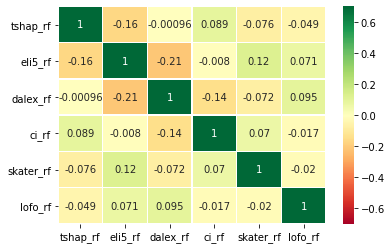

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

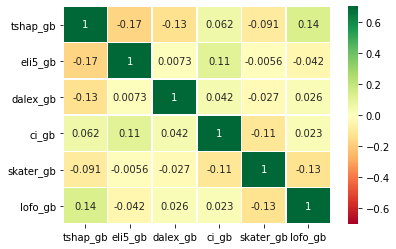

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: sonar
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:24
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/40/sonar.arff
OpenML URL....: https://www.openml.org/d/40
# of features.: 61
# of instances: 208>
All numeric
    attribute_1  attribute_2  ...  attribute_59  attribute_60
0      0.136431     0.156451  ...      0.245179      0.060046
1      0.323009     0.221603  ...      0.140496      0.087760
2      0.182153     0.246892  ...      0.258953      0.166282
3      0.062684     0.070724  ...      0.107438      0.256351
4      0.550885     0.282898  ...      0.292011      0.203233
..          ...          ...  ...           ...           ...
95     0.203540     0.168881  ...      0.380165      0.242494
96     0.122419     0.060009  ...      0.242424      0.182448
97     0.351032     0.117017  ...      0.911846      1.000000
98     0.957227     1.000000  ...      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.9s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   27.2s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   32.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.825397      0.875  0.724138

## confusion matrix  rf  ##
  Correct True:  0.9117647058823529  Uncorrect True:  0.08823529411764706
Uncorrect True:  0.27586206896551724    Correct True:  0.7241379310344828
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   13.6s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.825397      0.875  0.724138

## confusion matrix  gb  ##
  Correct True:  0.9117647058823529  Uncorrect True:  0.08823529411764706
Uncorrect True:  0.27586206896551724    Correct True:  0.7241379310344828


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

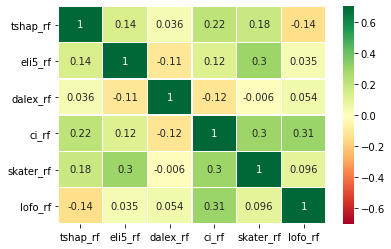

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

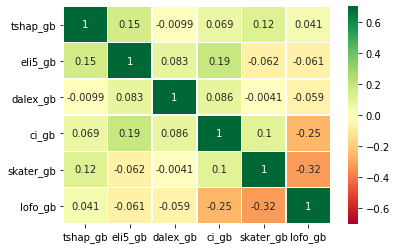

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: spambase
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:41
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/44/spambase.arff
OpenML URL....: https://www.openml.org/d/44
# of features.: 58
# of instances: 4601>
All numeric
    word_freq_make  ...  capital_run_length_total
0         0.000000  ...                  0.017487
1         0.046256  ...                  0.064836
2         0.013216  ...                  0.142551
3         0.000000  ...                  0.011995
4         0.000000  ...                  0.011995
..             ...  ...                       ...
95        0.000000  ...                  0.005682
96        0.000000  ...                  0.019697
97        0.000000  ...                  0.013952
98        0.000000  ...                  0.011995
99        0.273128  ...                  0.007134

[100 rows x 57 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   44.0s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   58.6s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.935554   0.957746   0.875

## confusion matrix  rf  ##
  Correct True:  0.974910394265233  Uncorrect True:  0.025089605734767026
Uncorrect True:  0.125    Correct True:  0.875
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  61 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done 183 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.4min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.958001   0.955056  0.9375

## confusion matrix  gb  ##
  Correct True:  0.9713261648745519  Uncorrect True:  0.02867383512544803
Uncorrect True:  0.0625    Correct True:  0.9375


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

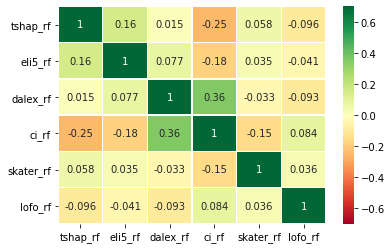

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

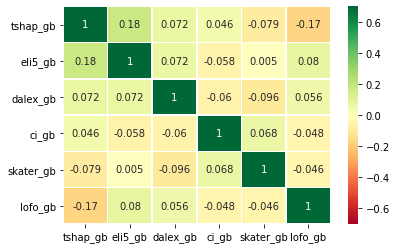

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: qsar-biodeg
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-25 21:14:53
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1592286/qsar-biodeg.arff
OpenML URL....: https://www.openml.org/d/1494
# of features.: 42
# of instances: 1055>
All numeric
          V1        V2        V3   V4   V5  ...       V37    V38       V39  V40  V41
0   0.426824  0.225351  0.000000  0.0  0.0  ...  0.028453  0.000  0.238782  0.0  0.0
1   0.482651  0.156504  0.000000  0.0  0.0  ...  0.114732  0.000  0.239190  0.0  0.0
2   0.429715  0.292264  0.000000  0.0  0.0  ...  0.217990  0.000  0.274353  0.0  0.0
3   0.222420  0.227608  0.000000  0.0  0.0  ...  0.810693  0.000  0.181233  0.0  0.0
4   0.497331  0.309365  0.000000  0.0  0.0  ...  0.215236  0.000  0.315445  0.0  0.0
..       ...       ...       ...  ...  ...  ...       ...    ...       ...  ...  ...
95  0.591415  0.347963  0.166667  0.0  0.0  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   31.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   38.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.880126   0.877193  0.952381

## confusion matrix  rf  ##
  Correct True:  0.9523809523809523  Uncorrect True:  0.047619047619047616
Uncorrect True:  0.2616822429906542    Correct True:  0.7383177570093458
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  63 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   35.9s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   37.2s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision   Recall
0  0.861199   0.873874  0.92381

## confusion matrix  gb  ##
  Correct True:  0.9238095238095239  Uncorrect True:  0.0761904761904762
Uncorrect True:  0.2616822429906542    Correct True:  0.7383177570093458


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

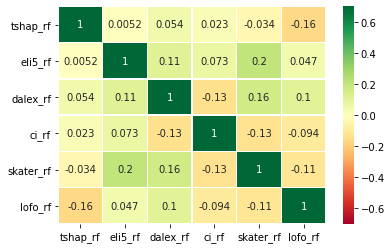

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

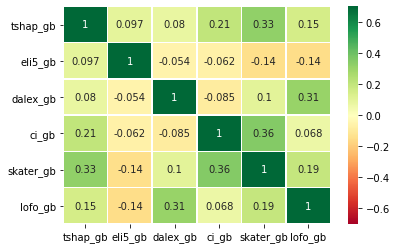

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: kc3
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:40
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53948/kc3.arff
OpenML URL....: https://www.openml.org/d/1065
# of features.: 40
# of instances: 458>
All numeric
    LOC_BLANK  BRANCH_COUNT  ...  PERCENT_COMMENTS  LOC_TOTAL
0    0.000000      0.000000  ...          0.000000   0.012397
1    0.035714      0.068966  ...          0.000000   0.045455
2    0.000000      0.000000  ...          0.000000   0.012397
3    0.000000      0.000000  ...          0.000000   0.012397
4    0.178571      0.293103  ...          0.048436   0.239669
..        ...           ...  ...               ...        ...
95   0.000000      0.034483  ...          0.000000   0.037190
96   0.000000      0.000000  ...          0.000000   0.020661
97   0.285714      0.258621  ...          0.237964   0.190083
98   0.000000      0.000000  ...      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   26.0s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   31.4s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.905797   0.905797     1.0

## confusion matrix  rf  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   18.1s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.898551   0.923664   0.968

## confusion matrix  gb  ##
  Correct True:  0.23076923076923078  Uncorrect True:  0.7692307692307693
Uncorrect True:  0.032    Correct True:  0.968


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

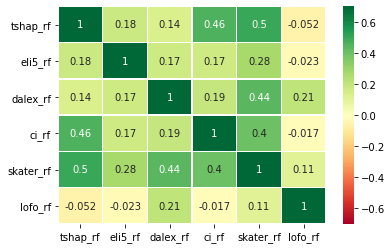

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

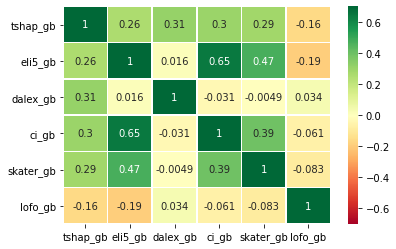

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: mc1
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:25
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53939/mc1.arff
OpenML URL....: https://www.openml.org/d/1056
# of features.: 39
# of instances: 9466>
All numeric
    LOC_BLANK  BRANCH_COUNT  ...  PERCENT_COMMENTS  LOC_TOTAL
0    0.000000      0.000000  ...          0.000000   0.000000
1    0.000000      0.000000  ...          0.000000   0.000000
2    0.000000      0.000000  ...          0.000000   0.000000
3    0.091954      0.045714  ...          0.440372   0.125196
4    0.045977      0.017143  ...          0.293755   0.037559
..        ...           ...  ...               ...        ...
95   0.011494      0.000000  ...          0.522139   0.006260
96   0.183908      0.028571  ...          0.417711   0.057903
97   0.000000      0.000000  ...          0.000000   0.000000
98   0.000000      0.000000  ...     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   50.9s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.995423   0.995761  0.999645

## confusion matrix  rf  ##
  Correct True:  0.4  Uncorrect True:  0.6
Uncorrect True:  0.0003546099290780142    Correct True:  0.999645390070922
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   59.8s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.5min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.996479   0.997521  0.998936

## confusion matrix  gb  ##
  Correct True:  0.65  Uncorrect True:  0.35
Uncorrect True:  0.0010638297872340426    Correct True:  0.9989361702127659


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

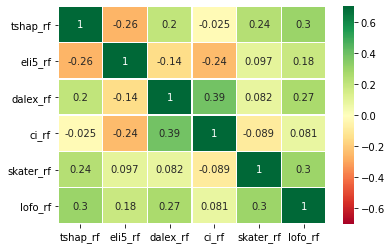

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

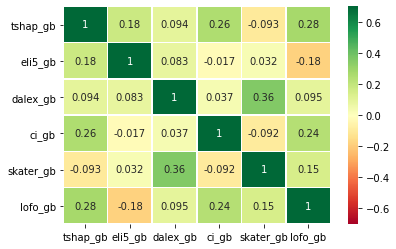

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: pc3
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:13
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53933/pc3.arff
OpenML URL....: https://www.openml.org/d/1050
# of features.: 38
# of instances: 1563>
All numeric
    LOC_BLANK  BRANCH_COUNT  ...  PERCENT_COMMENTS  LOC_TOTAL
0    0.025974      0.000000  ...          0.000000   0.012240
1    0.012987      0.000000  ...          0.000000   0.017136
2    0.350649      0.030612  ...          0.329040   0.051408
3    0.025974      0.027211  ...          0.000000   0.023256
4    0.077922      0.000000  ...          0.193528   0.011016
..        ...           ...  ...               ...        ...
95   0.025974      0.034014  ...          0.000000   0.025704
96   0.077922      0.006803  ...          0.081861   0.014688
97   0.000000      0.000000  ...          0.000000   0.004896
98   0.038961      0.000000  ...     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   32.7s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   41.9s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.897655        0.5  0.208333

## confusion matrix  rf  ##
  Correct True:  0.9762470308788599  Uncorrect True:  0.023752969121140142
Uncorrect True:  0.7916666666666666    Correct True:  0.20833333333333334
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  63 tasks      | elapsed:   10.7s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   45.3s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   47.0s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=1,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.895522        0.0     0.0

## confusion matrix  gb  ##
  Correct True:  0.997624703087886  Uncorrect True:  0.0023752969121140144
Uncorrect True:  1.0    Correct True:  0.0


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

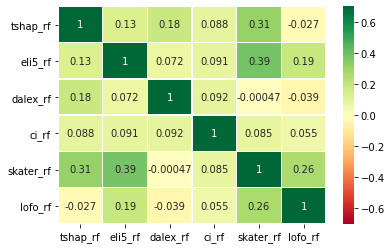

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

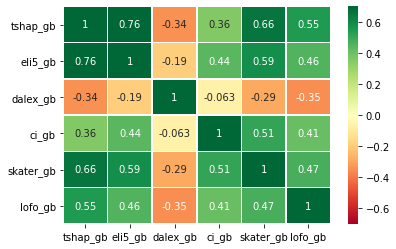

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: mw1
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:50
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53954/mw1.arff
OpenML URL....: https://www.openml.org/d/1071
# of features.: 38
# of instances: 403>
All numeric
@@@@ NOTE>: There arent preprocess in X dataset  mw1  @@@@
    LOC_BLANK  BRANCH_COUNT  ...  PERCENT_COMMENTS  LOC_TOTAL
0    0.058824      0.000000  ...          0.392118   0.027523
1    0.088235      0.081633  ...          0.294118   0.082569
2    0.117647      0.204082  ...          0.336118   0.155963
3    0.058824      0.122449  ...          0.069176   0.119266
4    0.029412      0.000000  ...          0.427765   0.036697
..        ...           ...  ...               ...        ...
95   0.029412      0.081633  ...          0.090471   0.082569
96   0.058824      0.122449  ...          0.000000   0.082569
97   0.117647      0.183673  ...         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   31.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.917355   0.932203  0.982143

## confusion matrix  rf  ##
  Correct True:  0.1111111111111111  Uncorrect True:  0.8888888888888888
Uncorrect True:  0.017857142857142856    Correct True:  0.9821428571428571
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   16.4s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=1,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.942149   0.941176     1.0

## confusion matrix  gb  ##
  Correct True:  0.2222222222222222  Uncorrect True:  0.7777777777777778
Uncorrect True:  0.0    Correct True:  1.0


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

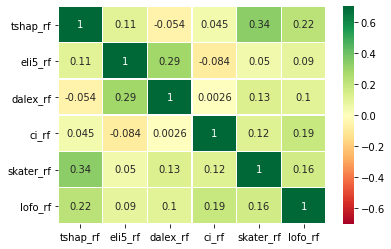

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

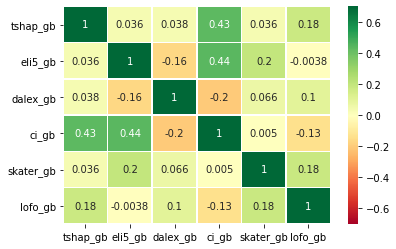

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: pc4
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:12
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53932/pc4.arff
OpenML URL....: https://www.openml.org/d/1049
# of features.: 38
# of instances: 1458>
All numeric
    LOC_BLANK  BRANCH_COUNT  ...  PERCENT_COMMENTS  LOC_TOTAL
0    0.188889      0.053763  ...          0.335949   0.114286
1    0.022222      0.043011  ...          0.107504   0.042857
2    0.022222      0.021505  ...          0.113201   0.085714
3    0.044444      0.021505  ...          0.000000   0.047619
4    0.077778      0.021505  ...          0.161256   0.095238
..        ...           ...  ...               ...        ...
95   0.044444      0.010753  ...          0.000000   0.042857
96   0.033333      0.010753  ...          0.000000   0.061905
97   0.033333      0.000000  ...          0.000000   0.033333
98   0.011111      0.032258  ...     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   31.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   39.1s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.901826       0.75  0.283019

## confusion matrix  rf  ##
  Correct True:  0.987012987012987  Uncorrect True:  0.012987012987012988
Uncorrect True:  0.7169811320754716    Correct True:  0.2830188679245283
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  63 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   41.4s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   43.2s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0   0.90411   0.641026  0.471698

## confusion matrix  gb  ##
  Correct True:  0.9636363636363636  Uncorrect True:  0.03636363636363636
Uncorrect True:  0.5283018867924528    Correct True:  0.4716981132075472


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

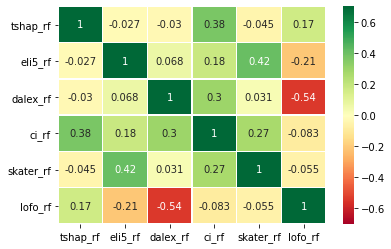

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

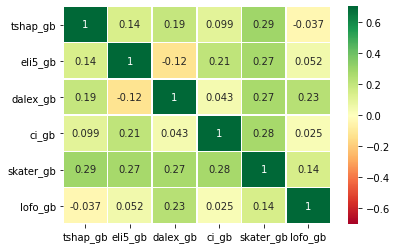

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: Satellite
Version.......: 1
Format........: ARFF
Upload Date...: 2017-09-22 17:23:34
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/16787463/Satellite.arff
OpenML URL....: https://www.openml.org/d/40900
# of features.: 37
# of instances: 5100>
All numeric
          V1        V2        V3    V4  ...       V33       V34       V35       V36
0   0.079365  0.110092  0.740260  0.95  ...  0.062500  0.038835  0.920455  0.957627
1   0.095238  0.082569  0.740260  0.89  ...  0.046875  0.019417  0.943182  0.966102
2   0.619048  0.614679  0.493506  0.30  ...  0.593750  0.543689  0.522727  0.381356
3   0.238095  0.211009  0.129870  0.16  ...  0.265625  0.271845  0.318182  0.305085
4   0.047619  0.055046  0.870130  0.96  ...  0.046875  0.019417  0.886364  0.872881
..       ...       ...       ...   ...  ...       ...       ...       ...       ...
95  0.809524  0.798165  0.636364  0.47  ...  0.828125

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   49.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.995425   0.995376     1.0

## confusion matrix  rf  ##
  Correct True:  0.6956521739130435  Uncorrect True:  0.30434782608695654
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   40.2s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.0min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.996078   0.996034     1.0

## confusion matrix  gb  ##
  Correct True:  0.7391304347826086  Uncorrect True:  0.2608695652173913
Uncorrect True:  0.0    Correct True:  1.0


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

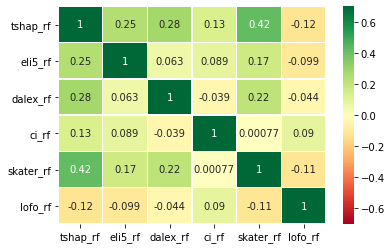

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

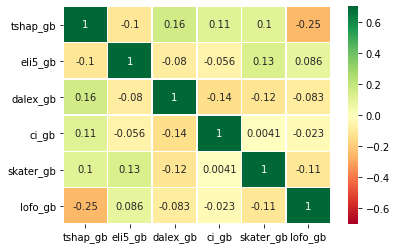

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: pc2
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:47
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53952/pc2.arff
OpenML URL....: https://www.openml.org/d/1069
# of features.: 37
# of instances: 5589>
All numeric
    BRANCH_COUNT  CALL_PAIRS  ...  PERCENT_COMMENTS  LOC_TOTAL
0       0.000000    0.000000  ...          0.000000   0.000000
1       0.000000    0.013514  ...          0.000000   0.000000
2       0.000000    0.054054  ...          0.977796   0.012066
3       0.000000    0.013514  ...          0.941966   0.018100
4       0.000000    0.013514  ...          0.000000   0.001508
..           ...         ...  ...               ...        ...
95      0.000000    0.013514  ...          0.000000   0.000000
96      0.020979    0.054054  ...          0.865059   0.010558
97      0.000000    0.000000  ...          0.000000   0.000000
98      0.006993    0.02702

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   39.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   50.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.995826   0.995826     1.0

## confusion matrix  rf  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:   11.3s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   51.1s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0   0.99523   0.995823  0.999401

## confusion matrix  gb  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0005988023952095808    Correct True:  0.9994011976047904


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

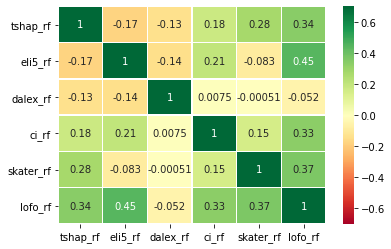

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

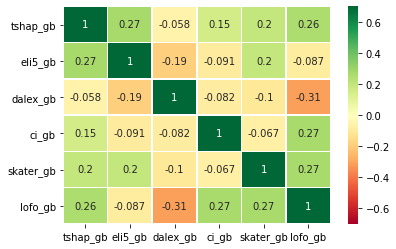

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: steel-plates-fault
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-25 22:42:40
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1592296/steel-plates-fault.arff
OpenML URL....: https://www.openml.org/d/1504
# of features.: 34
# of instances: 1941>
All numeric
    X_Minimum  X_Maximum  Y_Minimum  ...  Stains  Dirtiness  Bumps
0    0.024633   0.026916   0.020352  ...     0.0        0.0    0.0
1    0.378299   0.378584   0.195006  ...     0.0        0.0    0.0
2    0.486217   0.486249   0.119190  ...     0.0        0.0    0.0
3    0.500293   0.500878   0.027938  ...     0.0        0.0    0.0
4    0.756012   0.761849   0.037853  ...     0.0        0.0    0.0
..        ...        ...        ...  ...     ...        ...    ...
95   0.326686   0.331188   0.186348  ...     0.0        0.0    0.0
96   0.620528   0.621416   0.027788  ...     0.0        0.0    0.0
97   0.457478   0.4581

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   36.6s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   48.0s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.993139   0.994751  0.994751

## confusion matrix  rf  ##
  Correct True:  0.994750656167979  Uncorrect True:  0.005249343832020997
Uncorrect True:  0.009900990099009901    Correct True:  0.9900990099009901
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   46.7s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   48.6s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0       1.0        1.0     1.0

## confusion matrix  gb  ##
  Correct True:  1.0  Uncorrect True:  0.0
Uncorrect True:  0.0    Correct True:  1.0


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

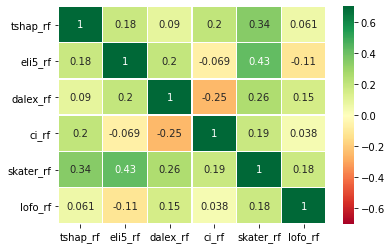

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

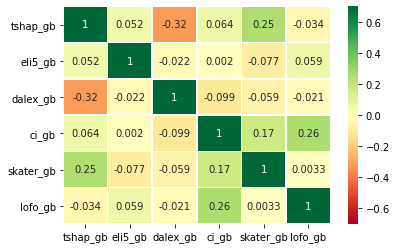

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: kc2
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:36
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53946/kc2.arff
OpenML URL....: https://www.openml.org/d/1063
# of features.: 22
# of instances: 522>
All numeric
         loc      v(g)     ev(g)  ...  total_Op  total_Opnd  branchCount
0   0.000078  0.002235  0.003226  ...  0.000081    0.000793     0.001111
1   0.000000  0.000000  0.000000  ...  0.000000    0.000661     0.000000
2   0.324961  0.324022  0.395161  ...  0.279984    0.308658     0.291667
3   0.179749  0.178771  0.072581  ...  0.138574    0.153338     0.177778
4   0.136578  0.139665  0.088710  ...  0.125203    0.125578     0.138889
..       ...       ...       ...  ...       ...         ...          ...
95  0.005495  0.000000  0.000000  ...  0.001216    0.003966     0.000000
96  0.004710  0.000000  0.000000  ...  0.003647    0.008592     0.000000
9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   26.3s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   31.8s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.847134        0.7  0.4375

## confusion matrix  rf  ##
  Correct True:  0.952  Uncorrect True:  0.048
Uncorrect True:  0.5625    Correct True:  0.4375
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   21.0s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0  0.853503   0.736842  0.4375

## confusion matrix  gb  ##
  Correct True:  0.96  Uncorrect True:  0.04
Uncorrect True:  0.5625    Correct True:  0.4375


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

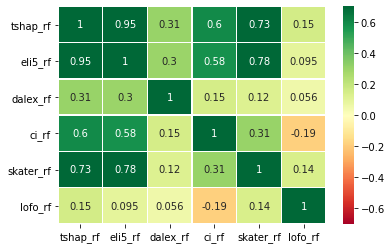

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

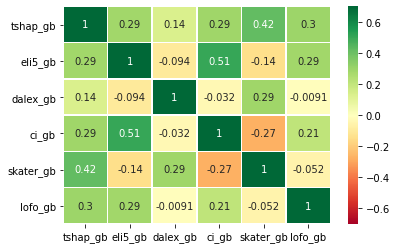

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: pc1
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:45
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53951/pc1.arff
OpenML URL....: https://www.openml.org/d/1068
# of features.: 22
# of instances: 1109>
All numeric
         loc      v(g)     ev(g)  ...  total_Op  total_Opnd  branchCount
0   0.001827  0.002963  0.003279  ...  0.000122    0.001049     0.001702
1   0.001661  0.000000  0.000000  ...  0.000000    0.000874     0.000000
2   0.151163  0.059259  0.016393  ...  0.116463    0.110140     0.068085
3   0.181063  0.148148  0.032787  ...  0.139024    0.132867     0.157447
4   0.838870  0.777778  0.327869  ...  0.851220    0.823427     0.753191
..       ...       ...       ...  ...       ...         ...          ...
95  0.011628  0.000000  0.000000  ...  0.010366    0.011364     0.000000
96  0.014950  0.007407  0.000000  ...  0.009146    0.012238     0.008511


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   29.0s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   36.1s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.948949   0.714286  0.434783

## confusion matrix  rf  ##
  Correct True:  0.9870967741935484  Uncorrect True:  0.012903225806451613
Uncorrect True:  0.5652173913043478    Correct True:  0.43478260869565216
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   31.6s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0   0.93994        0.6  0.391304

## confusion matrix  gb  ##
  Correct True:  0.9806451612903225  Uncorrect True:  0.01935483870967742
Uncorrect True:  0.6086956521739131    Correct True:  0.391304347826087


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

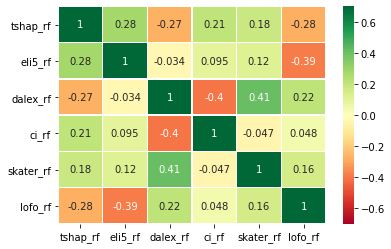

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

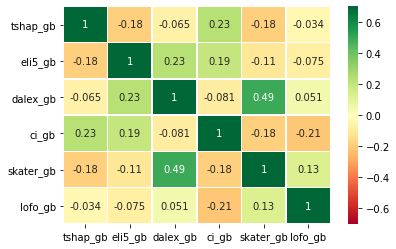

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: kc1
Version.......: 1
Format........: ARFF
Upload Date...: 2014-10-06 23:57:43
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/53950/kc1.arff
OpenML URL....: https://www.openml.org/d/1067
# of features.: 22
# of instances: 2109>
All numeric
         loc      v(g)  ev(g)  ...  total_Op  total_Opnd  branchCount
0   0.000348  0.009091  0.016  ...  0.001770    0.002804     0.004545
1   0.000000  0.000000  0.000  ...  0.001475    0.002336     0.000000
2   0.285714  0.227273  0.000  ...  0.157817    0.149533     0.227273
3   0.156794  0.159091  0.200  ...  0.131268    0.121495     0.159091
4   0.083624  0.045455  0.000  ...  0.060472    0.039720     0.045455
..       ...       ...    ...  ...       ...         ...          ...
95  0.024390  0.000000  0.000  ...  0.022124    0.025701     0.000000
96  0.128920  0.113636  0.080  ...  0.150442    0.151869     0.113636
97  0.160279  0.272727  0.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   41.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision   Recall
0  0.862559   0.627907  0.27551

## confusion matrix  rf  ##
  Correct True:  0.9700934579439252  Uncorrect True:  0.029906542056074768
Uncorrect True:  0.7244897959183674    Correct True:  0.2755102040816326
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   47.7s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   49.4s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.853081   0.575758  0.193878

## confusion matrix  gb  ##
  Correct True:  0.9738317757009346  Uncorrect True:  0.026168224299065422
Uncorrect True:  0.8061224489795918    Correct True:  0.19387755102040816


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

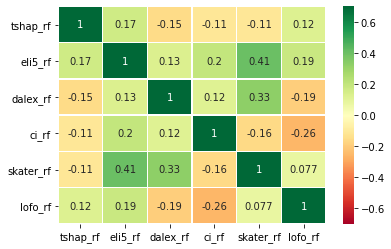

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

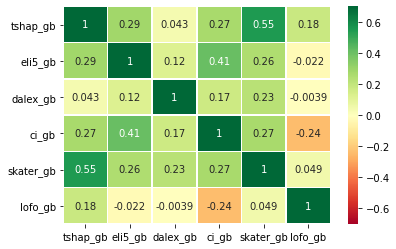

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: climate-model-simulation-crashes
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-21 23:11:45
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1586232/climate-model-simulation-crashes.arff
OpenML URL....: https://www.openml.org/d/1467
# of features.: 21
# of instances: 540>
All numeric
     V1        V2        V3        V4  ...       V17       V18       V19       V20
0   0.0  0.000000  0.929499  0.928789  ...  0.307275  0.860539  0.797506  0.870159
1   0.0  0.005587  0.460111  0.457227  ...  0.346527  0.356976  0.438628  0.512304
2   0.0  0.011173  0.372913  0.372473  ...  0.315136  0.250660  0.285678  0.365817
3   0.0  0.016760  0.102041  0.102451  ...  0.978783  0.848105  0.699851  0.476013
4   0.0  0.022346  0.513915  0.512870  ...  0.042881  0.377136  0.280135  0.132100
..  ...       ...       ...       ...  ...       ...       ...       ...       ...
95  0.0  0.530726

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   27.1s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   33.1s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0   0.91358        0.0     0.0

## confusion matrix  rf  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.9s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   19.5s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.907407   0.333333  0.071429

## confusion matrix  gb  ##
  Correct True:  0.07142857142857142  Uncorrect True:  0.9285714285714286
Uncorrect True:  0.013513513513513514    Correct True:  0.9864864864864865


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

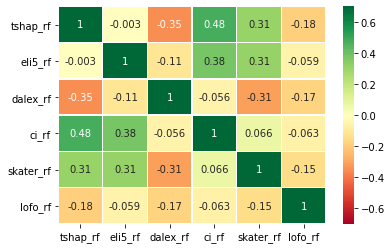

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

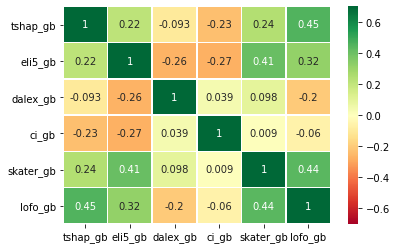

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: analcatdata_lawsuit
Version.......: 1
Format........: ARFF
Upload Date...: 2014-09-28 23:50:49
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/52562/analcatdata_lawsuit.arff
OpenML URL....: https://www.openml.org/d/450
# of features.: 5
# of instances: 264>
    Length.of.service       CAP  PA.normalized  Minority
0            0.058768  0.018519       0.076843       0.0
1            0.089573  0.037037       0.076843       0.0
2            0.000000  0.092593       0.115265       0.0
3            0.019668  0.185185       0.000000       0.0
4            0.159716  0.000000       0.422638       0.0
..                ...       ...            ...       ...
95           0.153791  0.481481       0.654206       0.0
96           0.713270  0.296296       0.731049       0.0
97           0.350474  0.370370       0.769470       1.0
98           0.236730  0.462963       0.654206       0.0
99           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   24.6s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   29.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0     0.925        0.0     0.0

## confusion matrix  rf  ##
  Correct True:  1.0  Uncorrect True:  0.0
Uncorrect True:  1.0    Correct True:  0.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   10.9s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision  Recall
0    0.9875   0.857143     1.0

## confusion matrix  gb  ##
  Correct True:  0.9864864864864865  Uncorrect True:  0.013513513513513514
Uncorrect True:  0.0    Correct True:  1.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

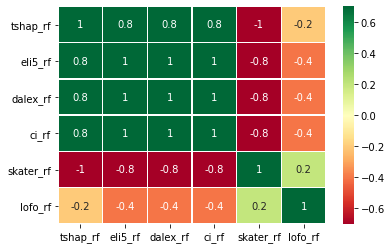

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

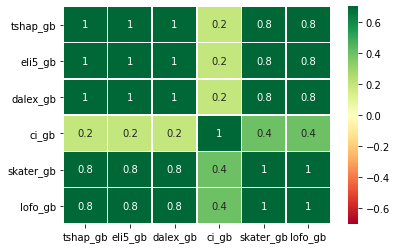

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

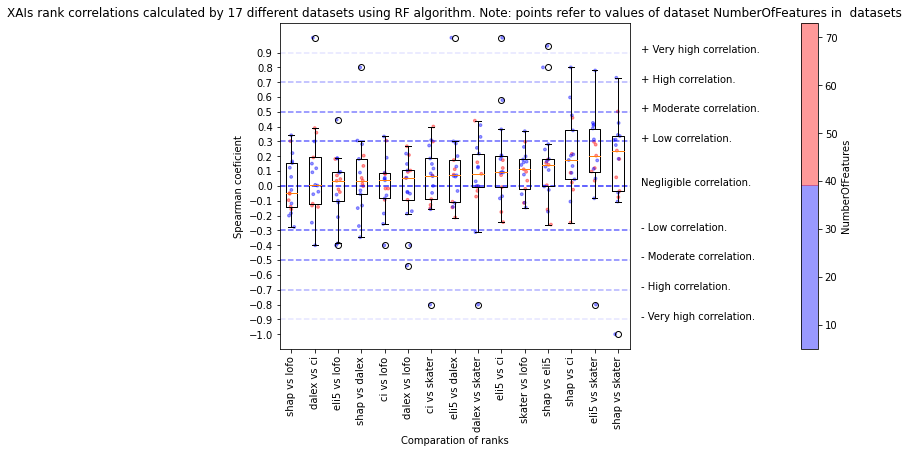

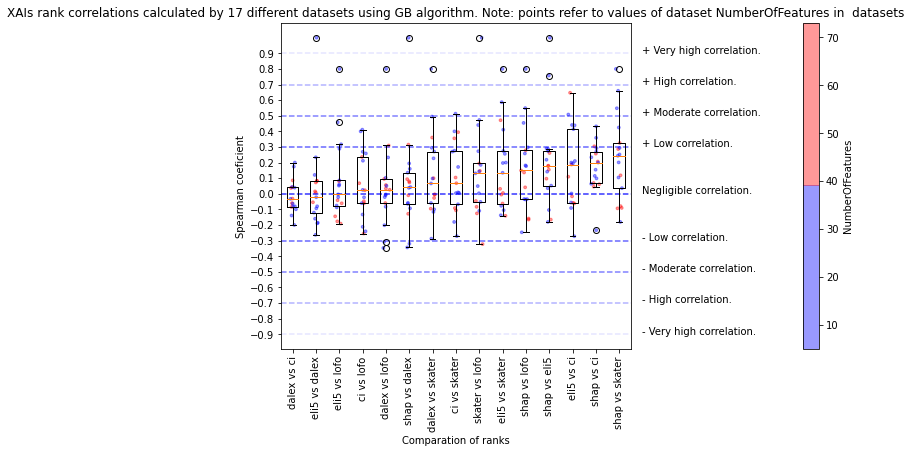

In [85]:
cluster = 0
df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
main_benchmark(list_dataset, df_prop_tmp)

## Execute benchmark to cluster 1

## Execution of benchmark to: 
['ionosphere', 'wdbc', 'credit-g', 'churn', 'Australian', 'eeg-eye-state', 'heart-statlog', 'ilpd', 'tic-tac-toe', 'jEdit_4.0_4.2', 'diabetes', 'prnn_crabs', 'monks-problems-1', 'monks-problems-3', 'monks-problems-2', 'delta_ailerons', 'mozilla4', 'phoneme', 'blood-transfusion-service-center', 'banknote-authentication', 'haberman']
<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: ionosphere
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:23:29
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/59/ionosphere.arff
OpenML URL....: https://www.openml.org/d/59
# of features.: 35
# of instances: 351>
All numeric
    a01  a02       a03       a04  ...       a31       a32       a33       a34
0   1.0    0  0.997695  0.470555  ...  0.711335  0.227565  0.593205  0.273500
1   1.0    0  1.000000  0.405855  ...  0.416870  0.468560  0.431310  0.487765
2   1.0    0  1.000000  0.483175  ...  0.802180  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   26.5s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   32.3s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.971698   0.948718  0.973684

## confusion matrix  rf  ##
  Correct True:  0.9705882352941176  Uncorrect True:  0.029411764705882353
Uncorrect True:  0.02631578947368421    Correct True:  0.9736842105263158
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   16.2s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.971698   0.948718  0.973684

## confusion matrix  gb  ##
  Correct True:  0.9705882352941176  Uncorrect True:  0.029411764705882353
Uncorrect True:  0.02631578947368421    Correct True:  0.9736842105263158


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

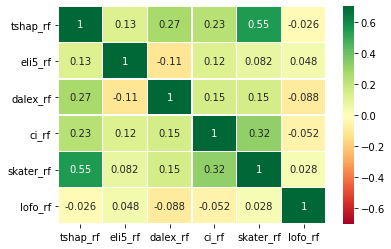

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

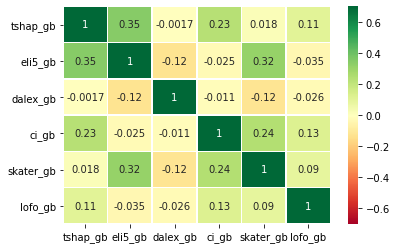

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: wdbc
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-26 16:24:07
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1592318/wdbc.arff
OpenML URL....: https://www.openml.org/d/1510
# of features.: 31
# of instances: 569>
All numeric
          V1        V2        V3  ...       V28       V29       V30
0   0.521037  0.022658  0.545989  ...  0.912027  0.598462  0.418864
1   0.643144  0.272574  0.615783  ...  0.639175  0.233590  0.222878
2   0.601496  0.390260  0.595743  ...  0.835052  0.403706  0.213433
3   0.210090  0.360839  0.233501  ...  0.884880  1.000000  0.773711
4   0.629893  0.156578  0.630986  ...  0.558419  0.157500  0.142595
..       ...       ...       ...  ...       ...       ...       ...
95  0.628473  0.450457  0.612328  ...  0.540550  0.418687  0.187853
96  0.246060  0.274941  0.234953  ...  0.202131  0.130495  0.122786
97  0.132803  0.345959  0.126598  ...  0.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   27.5s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   33.6s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.964912   0.971963  0.971963

## confusion matrix  rf  ##
  Correct True:  0.9719626168224299  Uncorrect True:  0.028037383177570093
Uncorrect True:  0.046875    Correct True:  0.953125
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   18.7s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=1,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.959064   0.962963  0.971963

## confusion matrix  gb  ##
  Correct True:  0.9719626168224299  Uncorrect True:  0.028037383177570093
Uncorrect True:  0.0625    Correct True:  0.9375


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

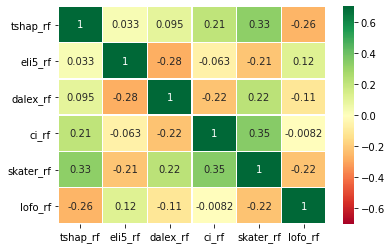

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

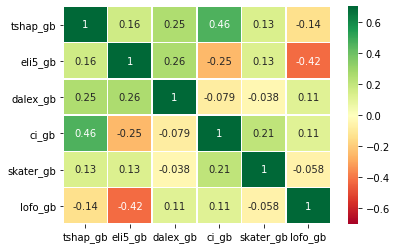

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: credit-g
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:21:47
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/31/credit-g.arff
OpenML URL....: https://www.openml.org/d/31
# of features.: 21
# of instances: 1000>
    checking_status  duration  ...  own_telephone  foreign_worker
0          0.637462  0.029412  ...            1.0             1.0
1          0.622356  0.647059  ...            0.0             1.0
2          1.000000  0.117647  ...            0.0             1.0
3          0.637462  0.558824  ...            0.0             1.0
4          0.637462  0.294118  ...            0.0             1.0
..              ...       ...  ...            ...             ...
95         0.622356  0.735294  ...            1.0             1.0
96         1.000000  0.117647  ...            0.0             1.0
97         0.622356  0.205882  ...            0.0             1.0
98  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   27.5s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   33.4s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.766667   0.775591  0.938095

## confusion matrix  rf  ##
  Correct True:  0.36666666666666664  Uncorrect True:  0.6333333333333333
Uncorrect True:  0.06190476190476191    Correct True:  0.9380952380952381
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  63 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:   37.8s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   39.0s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.766667   0.799145  0.890476

## confusion matrix  gb  ##
  Correct True:  0.4777777777777778  Uncorrect True:  0.5222222222222223
Uncorrect True:  0.10952380952380952    Correct True:  0.8904761904761904


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

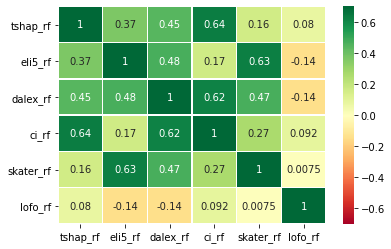

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

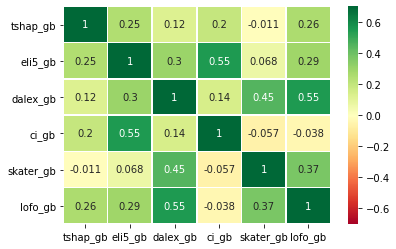

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: churn
Version.......: 1
Format........: ARFF
Upload Date...: 2017-04-06 12:37:40
Licence.......: public
Download URL..: https://www.openml.org/data/v1/download/4965302/churn.arff
OpenML URL....: https://www.openml.org/d/40701
# of features.: 21
# of instances: 5000>
    state  account_length  ...  total_intl_charge  number_customer_service_calls
0    0.32        0.524793  ...           0.500000                       1.000000
1    0.70        0.438017  ...           0.685185                       1.000000
2    0.62        0.561983  ...           0.609259                       0.572309
3    0.70        0.342975  ...           0.329630                       0.630605
4    0.72        0.305785  ...           0.505556                       0.371637
..    ...             ...  ...                ...                            ...
95   0.00        0.425620  ...           0.490741                       1.000000
96   0.52     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   57.2s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.4min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.954667   0.944444  0.721698

## confusion matrix  rf  ##
  Correct True:  0.9930124223602484  Uncorrect True:  0.006987577639751553
Uncorrect True:  0.2783018867924528    Correct True:  0.7216981132075472
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  1.3min


In [ ]:
cluster = 1
df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
main_benchmark(list_dataset, df_prop_tmp)


## Execute benchmark to cluster 2

## Execution of benchmark to: 
['kr-vs-kp', 'PhishingWebsites', 'SPECT']
<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: kr-vs-kp
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:19:28
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/3/kr-vs-kp.arff
OpenML URL....: https://www.openml.org/d/3
# of features.: 37
# of instances: 3196>
    bkblk  bknwy  bkon8  bkona  bkspr  ...  wkna8  wknck  wkovl  wkpos  wtoeg
0     1.0    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0    1.0
1     1.0    1.0    1.0    1.0    0.0  ...    1.0    1.0    1.0    1.0    1.0
2     1.0    1.0    1.0    1.0    0.0  ...    1.0    1.0    1.0    1.0    1.0
3     1.0    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0    1.0
4     1.0    1.0    1.0    1.0    1.0  ...    1.0    1.0    1.0    1.0    1.0
..    ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
95    1.0    1.0    1.0    1.0    1.0  ...    1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   32.6s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   39.9s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.976017   0.970472  0.984032

## confusion matrix  rf  ##
  Correct True:  0.9672489082969432  Uncorrect True:  0.03275109170305677
Uncorrect True:  0.015968063872255488    Correct True:  0.9840319361277445
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=3)]: Done 186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.995829   0.996008  0.996008

## confusion matrix  gb  ##
  Correct True:  0.9956331877729258  Uncorrect True:  0.004366812227074236
Uncorrect True:  0.003992015968063872    Correct True:  0.9960079840319361


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

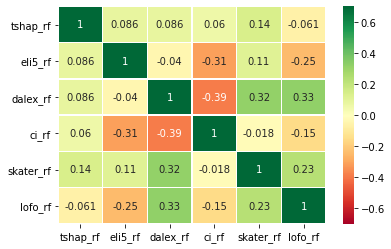

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

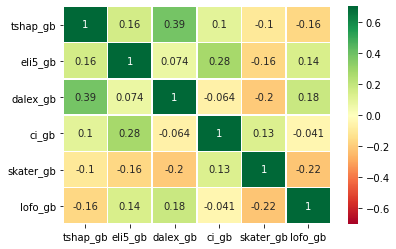

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: PhishingWebsites
Version.......: 1
Format........: ARFF
Upload Date...: 2016-02-16 15:30:33
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/1798106/PhishingWebsites.arff
OpenML URL....: https://www.openml.org/d/4534
# of features.: 31
# of instances: 11055>
    having_IP_Address  URL_Length  ...  Links_pointing_to_page  Statistical_report
0                 0.0    0.206799  ...                0.678138                 0.0
1                 1.0    0.206799  ...                0.678138                 1.0
2                 1.0    0.000000  ...                1.000000                 0.0
3                 1.0    0.000000  ...                0.000000                 1.0
4                 1.0    0.000000  ...                0.678138                 1.0
..                ...         ...  ...                     ...                 ...
95                1.0    1.000000  ...                0.678

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   10.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   48.8s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision    Recall
0  0.953271   0.952891  0.963725

## confusion matrix  rf  ##
  Correct True:  0.9401360544217687  Uncorrect True:  0.05986394557823129
Uncorrect True:  0.03627504060638874    Correct True:  0.9637249593936112
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:  2.9min finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.969249   0.966328  0.978885

## confusion matrix  gb  ##
  Correct True:  0.9571428571428572  Uncorrect True:  0.04285714285714286
Uncorrect True:  0.021115322144017325    Correct True:  0.9788846778559827


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

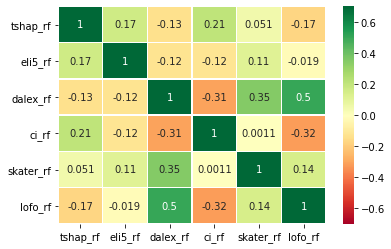

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

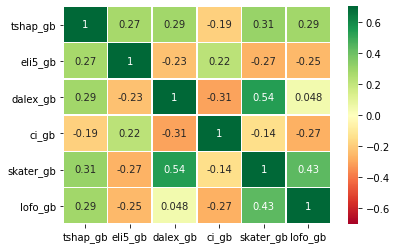

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: SPECT
Version.......: 1
Format........: ARFF
Upload Date...: 2014-08-26 17:57:57
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/52239/SPECT.arff
OpenML URL....: https://www.openml.org/d/336
# of features.: 23
# of instances: 267>
     F1   F2   F3   F4   F5   F6   F7  ...  F16  F17  F18  F19  F20  F21  F22
0   1.0  1.0  1.0  0.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1   1.0  1.0  0.0  0.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  0.0
2   0.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3   1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0  0.0  0.0  0.0
4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  1.0  1.0  1.0  1.0  1.0  1.0
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
95  0.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  1.0  0.0  1.0  1.0  0.0  1.0
96  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ... 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    7.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   30.9s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

   Accuracy  Precision  Recall
0  0.790123   0.790123     1.0

## confusion matrix  rf  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 192 out of 192 | elapsed:   15.8s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=1,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

   Accuracy  Precision    Recall
0  0.888889   0.887324  0.984375

## confusion matrix  gb  ##
  Correct True:  0.5294117647058824  Uncorrect True:  0.47058823529411764
Uncorrect True:  0.015625    Correct True:  0.984375


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

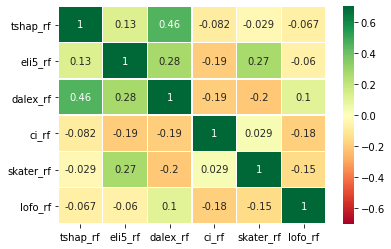

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

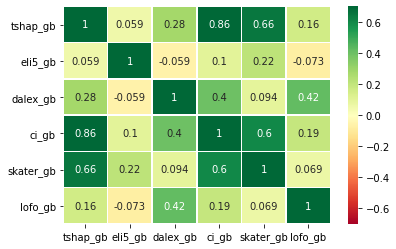

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

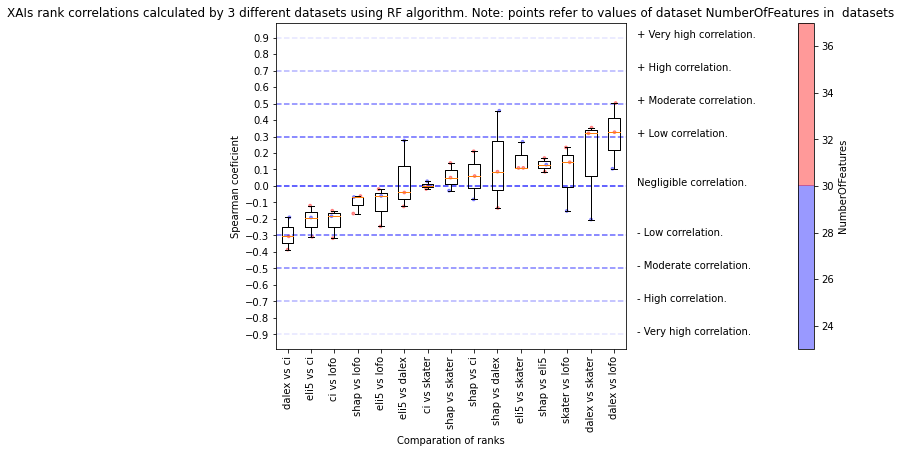

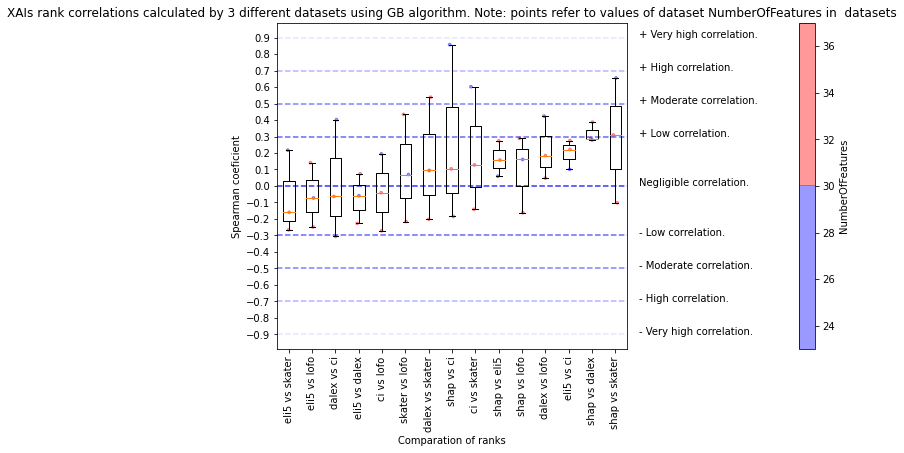

In [84]:
cluster = 2
df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
main_benchmark(list_dataset, df_prop_tmp)